# imports and functions

In [262]:
import pandas as pd
from os import chdir
import re
import requests
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from bs4 import BeautifulSoup
from bs4 import element
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

## scraper functions (uriya's and mine) 

In [24]:

#Helps parse miscellaneous tags <i>, </br>, etc,.
def _lyricsHelper(html, lyrics_list):
    for tag in html.childGenerator():
        if type(tag) == element.NavigableString:
            _handleLyricAppend(lyrics_list, tag.text.strip())
        elif tag.name == 'br' and lyrics_list[len(lyrics_list) - 1] != '':
            lyrics_list.append('')
        elif html.name == 'a':
            _lyricsHelper(tag, lyrics_list)

#Reads the HTML for lyrics dividers (if they exist) and appends the lyrics line by line to a list
def _getLyricsFromHTML(html):
    lyrics = html.findAll("div", {"data-lyrics-container" : "true"})
    lyrics_list = ['']
    for segment in lyrics:
        for a in segment.childGenerator():
            lyric = None
            if type(a) == element.NavigableString:
                lyric = a.strip()
                _handleLyricAppend(lyrics_list, lyric)
            else:
                _lyricsHelper(a, lyrics_list)
            if a.name == 'br' and lyrics_list[len(lyrics_list) - 1] != '':
                lyrics_list.append('')
    return lyrics_list

#Helper function to handle appending and manipulating lyrics_list. A new line is generated only for </br> tags
def _handleLyricAppend(lyrics_list, lyric):
    if lyric is not None:
        last_index = len(lyrics_list) - 1
        #Handle special cases (parenthesis and symbols stick with words for instance)
        if lyrics_list[last_index] != '' and (lyrics_list[last_index][-1] in ['(','[','{','<'] or lyric in [')',']','}','>','!','?',',','.']):
            lyrics_list[last_index] += lyric
        else:
            lyrics_list[last_index] += " " + lyric if lyrics_list[last_index] != '' else lyric

#Determines whether a song will need to be translated (returns the link if it does, otherwise returns None)
def _getSongTranslationLink(html):
    translation_tags = html.find_all('a', {"class": re.compile('TextButton*')})
    for tag in translation_tags:
        if "english-translations" in tag['href']:
            return tag['href']
    return None

#Determines whether a page exists
def _pageExists(html):
    return html.find('div', class_='render_404') == None
        
#function to scrape lyrics from genius, takes an array of artists, and songname
def scrapeLyrics(artistnames, songname):
    lyrics_list = []
    found = False
    i = 0
    html = None
    while i < len(artistnames) and not(found):
        artistname = artistnames[i]
        artistname2 = str(artistname.replace(' ','-')) if ' ' in artistname else str(artistname)
        songname2 = str(songname.replace(' ','-')) if ' ' in songname else str(songname)
        page_url = 'https://genius.com/'+ artistname2 + '-' + songname2 + '-' + 'lyrics'
        page = requests.get(page_url)
        html = BeautifulSoup(page.text, 'html.parser') 
        found = _pageExists(html)
        i += 1
    if found:
        #check if there is an english translation
        translation_url = _getSongTranslationLink(html)
        if translation_url is not None:
            page = requests.get(translation_url)
            html = BeautifulSoup(page.text, 'html.parser') 
            lyrics_list = _getLyricsFromHTML(html)
        else:
            #If there isn't a translation, make sure it's in english in the first place
            english = False
            for script in html.findAll('script'):
                if "language\\\":\\\"en" in str(script):
                    english = True
            if english: lyrics_list = _getLyricsFromHTML(html)
    return lyrics_list
    


In [25]:
def getTitlesAndArtists(sp, track_ids):
    titleArtistPairs = {}
    for i in range(0,len(track_ids),50):
        tracks = sp.tracks(track_ids[i:i+50])
        for track in tracks['tracks']:
            title=track['name']
            #check if the track ends with (feat. artist) using a regex
            if re.search(r' \(feat. .*\)$', title):
                #remove the (feat. artist) from the title
                title = re.sub(r' \(feat. .*\)$', '', title)

            artists=[]
            for artist in track['artists']:
                artists.append(artist['name'])
            titleArtistPairs[track['id']] = {'title':title,'artist(s)':artists}

    return titleArtistPairs

def getScrapedLyrics(scraperInputs):
        all_lyrics_dict = {}
        for id, songInfo in tqdm(scraperInputs.items()):
                #maybe add a sleep or something to prevent getting blocked
                lyrics = scrapeLyrics(songInfo['artist(s)'],songInfo['title'])
                if len(lyrics) > 0:
                        all_lyrics_dict[id]=lyrics
                        
        return all_lyrics_dict

# retrieving songs

In [2]:
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials('bf1ba68423404778a60bcf3dee58d199','7365dc611a2d4ddba4ad61343f0b64d7'))


In [8]:
chdir('C:/Users/mlar5/OneDrive/Desktop/Code Folder/Python Projects/IRL projects/Aspire - Affective Computing Project/Playlists Data/Audio Features/emotion joint data')

In [9]:
emotionsDF = pd.read_csv('Merged Emotions Data4.csv')

In [10]:
#get the unique mood ids
mood_ids = emotionsDF['mood'].unique()

In [11]:
# create a new df with only up to 500 songs per mood
# this is to balance the data

balancedDF = pd.DataFrame(columns=emotionsDF.columns)

for i in mood_ids:
    df = emotionsDF[emotionsDF['mood']==i]
    #if the value count of the mood is larger than 500, sample 500
    if df['mood'].value_counts()[i] > 100:
        df = df.sample(n=100, random_state=42)
    #if the value count of the mood is less than 500, sample the value count
    else:
        df = df.sample(n=df['mood'].value_counts()[i])
    balancedDF = pd.concat([balancedDF, df])

balancedDF['mood'].value_counts()

angry        100
calm         100
content      100
depressed    100
energetic    100
excited      100
happy        100
sad          100
Name: mood, dtype: int64

In [12]:
ids_dict = {}
#iterate through balancedDF and get the list of ids, using the mood as the key
for i in mood_ids:
    ids_dict[i] = balancedDF[balancedDF['mood']==i]['uri'].tolist()


In [13]:
for key in ids_dict.keys():
    ids_dict[key] = getTitlesAndArtists(sp, ids_dict[key])

In [14]:
ids_dict['sad']

{'419w8oZaqevgyZfdvFZEHa': {'title': 'Te Pintaron Pajaritos',
  'artist(s)': ['Yandar & Yostin', 'Andy Rivera']},
 '5rKvVyqtNT1EvrNuF9tLoF': {'title': "Llamé Pa' Verte",
  'artist(s)': ['Nio Garcia', 'Darell']},
 '5qFeMRz4TvetPmzjre9Dq7': {'title': 'No Es Justo',
  'artist(s)': ['J Balvin', 'Zion & Lennox']},
 '79aj4SR6l5FKOJqy1TdtSv': {'title': 'Fall In Love - Acoustic',
  'artist(s)': ['Bailey Zimmerman']},
 '6AzKhCHOms83jvNVLsz0Bt': {'title': 'Djadja (feat. Maluma) - Remix',
  'artist(s)': ['Aya Nakamura', 'Maluma']},
 '0QN1rkBy3D6j9Yw3Czlcsc': {'title': 'Ella Quiere Hmm... Haa... Hmm... - Yayo Remix',
  'artist(s)': ['Leka el Poeta', 'Mishelle Master Boys', 'DJ Yayo']},
 '4epozEKOwPtszj2zaKeVIP': {'title': 'with you', 'artist(s)': ['The Rose']},
 '2Q7KYjCv7XaLc0KRGY9m50': {'title': 'Bonita', 'artist(s)': ['Jeeiph']},
 '2BJy4svtrGACqRB5BFLOK6': {'title': 'Way of the Triune God - Hallelujah Version',
  'artist(s)': ['Tyler Childers']},
 '2bPEmMFmuV7Szif2UmK1t8': {'title': 'Congratula

In [15]:
for key in ids_dict.keys():
    ids_dict[key] = getScrapedLyrics(ids_dict[key])

  1%|          | 1/100 [00:00<00:26,  3.74it/s]

AAAA


  2%|▏         | 2/100 [00:02<02:32,  1.55s/it]

AAAA


 22%|██▏       | 22/100 [00:14<00:52,  1.48it/s]

AAAA


 30%|███       | 30/100 [00:19<01:11,  1.02s/it]

AAAA


  5%|▌         | 5/100 [00:01<00:27,  3.40it/s]

AAAA


 18%|█▊        | 18/100 [00:07<00:42,  1.93it/s]

AAAA


 31%|███       | 31/100 [00:12<00:27,  2.48it/s]

AAAA
AAAA


 41%|████      | 41/100 [00:18<00:44,  1.32it/s]

AAAA


 55%|█████▌    | 55/100 [00:24<00:15,  2.90it/s]

AAAA


 62%|██████▏   | 62/100 [00:26<00:14,  2.68it/s]

AAAA


 75%|███████▌  | 75/100 [00:31<00:08,  3.10it/s]

AAAA


 76%|███████▌  | 76/100 [00:35<00:30,  1.28s/it]

AAAA


 89%|████████▉ | 89/100 [00:43<00:08,  1.34it/s]

AAAA


 48%|████▊     | 48/100 [00:24<00:35,  1.46it/s]

AAAA


 60%|██████    | 60/100 [00:29<00:15,  2.56it/s]

AAAA


  3%|▎         | 3/100 [00:00<00:33,  2.86it/s]

AAAA


  7%|▋         | 7/100 [00:03<00:58,  1.59it/s]

AAAA


 34%|███▍      | 34/100 [00:12<00:21,  3.13it/s]

AAAA


 39%|███▉      | 39/100 [00:15<00:31,  1.94it/s]

AAAA


 44%|████▍     | 44/100 [00:18<00:39,  1.43it/s]

AAAA


 75%|███████▌  | 75/100 [00:35<00:07,  3.19it/s]

AAAA


 98%|█████████▊| 98/100 [00:50<00:00,  2.37it/s]

AAAA


100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


In [17]:
chdir('C:/Users/mlar5/OneDrive/Desktop/Code Folder/Python Projects/IRL projects/Aspire - Affective Computing Project/Playlists Data/Track Lyrics/')

1. save the lyrics to a csv
    1. first check if i have all the data i need to get original mood labels, ids, etc.
2. set up the return of the final value to determine how far off from prediction!
    1. i think i just return the mood and also the tuple of the prediction coordinates
3. have the model predict the mood of each song


In [26]:
#save the lyrics dict as a pickle file
with open('800_track_lyrics_dict.pkl', 'wb') as handle:
    pickle.dump(ids_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
for key in ids_dict.keys():
    print(key)
    print(len(ids_dict[key]))

angry
48
calm
33
content
50
depressed
49
energetic
24
excited
56
happy
45
sad
42


In [30]:
# convert ids_dict to a dataframe, with the key becoming 1 column called mood
ids_df = pd.DataFrame.from_dict(ids_dict)
ids_df.head()

,angry,calm,content,depressed,energetic,excited,happy,sad
1SSv8SA2OHfOUwLgb8yOum,"[[Chorus], Catch me on your block, Always mobb...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
0A8Mrg7ButLr17K3A0R61D,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN
7CMy59461Q3pgsPZ4Cj8CP,"[[INTRO], YEAHHHHHH, IMMA NEED YALL TO TURN TH...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
5FX30idriKlEIRYTxpNf65,"[I'm about to grab my 44, I pop the trunk so n...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2muf1caAmZ5AqPUFeIaP9r,"[[Intro], Thraxx, [Chorus: ZillaKami], I'm a d...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
#convert the nested dictionary ids_dict to a dataframe, with the key becoming 1 column called mood, and the subkeys becoming the index

ids_df = pd.DataFrame.from_dict(({(i,j): ids_dict[i][j]} for i in ids_dict.keys() for j in ids_dict[i].keys()))
ids_df.head()

,"(angry, 1SSv8SA2OHfOUwLgb8yOum)","(angry, 0A8Mrg7ButLr17K3A0R61D)","(angry, 7CMy59461Q3pgsPZ4Cj8CP)","(angry, 5FX30idriKlEIRYTxpNf65)","(angry, 2muf1caAmZ5AqPUFeIaP9r)","(angry, 4Zdp7FjQOG1ejeV06dUiv6)","(angry, 2Eb5AK8EUN8oz5nlzSr4b7)","(angry, 6nfnDSD5Wa9LAD8jeN5tix)","(angry, 0OEElGULHOyTpEGPkwS6qv)","(angry, 4evnuNKgYSrq1UFc9uK8Wp)",...,"(sad, 2OWVCFTolecLiGZPquvWvT)","(sad, 3ZFwuJwUpIl0GeXsvF1ELf)","(sad, 4nwgKaHg9TJahiSSmt3X1x)","(sad, 4eTIe5eqds88bA9ua6p5p6)","(sad, 6RQ5IwG7uADz9LDWliJGjU)","(sad, 4J8I1iX17piXYbzDwgP9Eh)","(sad, 4HcARAxzsbIB3MqiEkejM6)","(sad, 54q7FLhWb9FEObFBziNRTq)","(sad, 6cHJ8kH1lRa8lEEfD003oT)","(sad, 4uP3pUP18ennmz0tb3GphR)"
0,"[[Chorus], Catch me on your block, Always mobb...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,"[[INTRO], YEAHHHHHH, IMMA NEED YALL TO TURN TH...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,"[I'm about to grab my 44, I pop the trunk so n...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,"[[Intro], Thraxx, [Chorus: ZillaKami], I'm a d...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
import pandas as pd

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(ids_dict, orient='index')

# Transpose the DataFrame so that the song IDs become the row indices
df = df.transpose()

# Rename the index column to 'id'
df.index.name = 'id'

# Reset the index to make the 'id' column a regular column
df = df.reset_index()

# Rename the column containing the mood to 'mood'
df = df.rename(columns={'index': 'mood'})
df.tail()

,id,angry,calm,content,depressed,energetic,excited,happy,sad
342,4J8I1iX17piXYbzDwgP9Eh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[[Verse 1], There’s a fire burnin' in the base..."
343,4HcARAxzsbIB3MqiEkejM6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[[Verse 1], This is the last song I'll write a..."
344,54q7FLhWb9FEObFBziNRTq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[[Verse 1], Of course I do, Try not to think a..."
345,6cHJ8kH1lRa8lEEfD003oT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[[Verse 1], This is where it ends, I been down..."
346,4uP3pUP18ennmz0tb3GphR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[[Chorus], Don't call me again ""Baby"" (No!), I..."


In [36]:
# Reshape the DataFrame using melt to create a 'mood' and 'lyrics' column
df = pd.melt(df, id_vars=['id'], var_name='mood', value_name='lyrics')

# Drop any rows that have a NaN value in the 'lyrics' column
df = df.dropna(subset=['lyrics'])

# Reset the index of the DataFrame
df = df.reset_index(drop=True)

# Reorder the columns so that 'mood' comes before 'lyrics'
df = df[['mood', 'lyrics', 'id']]


In [37]:
df.head()

,mood,lyrics,id
0,angry,"[[Chorus], Catch me on your block, Always mobb...",1SSv8SA2OHfOUwLgb8yOum
1,angry,[],0A8Mrg7ButLr17K3A0R61D
2,angry,"[[INTRO], YEAHHHHHH, IMMA NEED YALL TO TURN TH...",7CMy59461Q3pgsPZ4Cj8CP
3,angry,"[I'm about to grab my 44, I pop the trunk so n...",5FX30idriKlEIRYTxpNf65
4,angry,"[[Intro], Thraxx, [Chorus: ZillaKami], I'm a d...",2muf1caAmZ5AqPUFeIaP9r


In [52]:
#get the total number or rows where the length of the lyrics is less than 10
df[df['lyrics'].str.len() < 2]

,mood,lyrics,id
1,angry,[],0A8Mrg7ButLr17K3A0R61D
57,calm,[],6NpMjx91zL5xZo5a1t3ON3
119,content,[],4SKBaun9EERfPsuLYqF1Fm
126,content,[],6Xks4cqxx4hVbjR8nnpAnW


In [46]:
len(ids_dict['angry']['0A8Mrg7ButLr17K3A0R61D'])

80

In [42]:
#save the df as a csv
df.to_csv('800_track_lyrics.csv', index=False)

# BERT Code (to be tested)

In [99]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import tensorflow as tf

def getOnlyMoodLabelFromLyrics(lyrics):
    
    #PART 1: DATA SETUP
    moods = ['sad','angry','energetic','excited','happy','content','calm','depressed']
    nums = [0, 1, 2, 3, 4, 5, 6, 7]

    # create dictionary mapping strings to integers
    mood_to_num = {mood: num for mood,num in zip(moods,nums)}
    
    #device = 'cuda' if cuda.is_available() else 'cpu'
    
    #change to ./path/goemotions_model
    BERT_model = AutoModelForSequenceClassification.from_pretrained("monologg/bert-base-cased-goemotions-original")
    #change to ./path/goemotions_tokenizer
    BERT_Tokenizer = AutoTokenizer.from_pretrained("monologg/bert-base-cased-goemotions-original")
    emotionsAsValenceArousal= { 'admiration':(.6,.4),'amusement':(.6,.2),'anger':(-.8,.6),'annoyance':(-.6,.6),'approval':(.8,.6),'caring':(.6,-.2),'confusion':(-.2,.2),'curiosity':(0,.4),'desire':(.6,.6),'disappointment':(-.6,-.6),'disapproval':(-.8,.65),'disgust':(-.8,.2),'embarrassment':(-.6,.4),'excitement':(.6,.8),'fear':(-.6,.8),'gratitude':(.6,-.6),'gratitude':(.6,-.6),'grief':(-.6,-.8),'joy':(.8,.2),'love':(.8,.4),'nervousness':(-.4,.6),'optimism':(.6,.2),'pride':(.6,.1),'realization':(.2,.2),'relief':(.4,-.4),'remorse':(-.6,-.4),'sadness':(-.8,-.2),'surprise':(.2,.6),'neutral':(0,0)}

    emotion_dict = BERT_model.config.id2label



    #PART 2 - get the mood label
    mood,relyOnLinearModel,valence, arousal = getMoodLabelFromLyrics(lyrics,BERT_model, BERT_Tokenizer, emotion_dict, emotionsAsValenceArousal, device='cpu',printValenceArousal=False)
    #mood = mood_to_num[mood]
    return mood,relyOnLinearModel, valence, arousal


def getMoodLabelFromLyrics(lyrics,model, tokenizer, emotion_dict, emotionsAsValenceArousal,printValenceArousal = False,disregardNeutral=True, printRawScores=False, printTopN=False,topScoresToPrint=3,max_length=512, device="cuda",  returnSongSegments=False):
    relyOnLinearResults = False
    softmaxScoresPerHeader = {}
    model.to(device)
    
    #part 1 - break up the lyrics into chunks and get the tokens
    if returnSongSegments:
        songTokenChunks,freqs,songSegs =breakUpSongByHeaders(lyrics,tokenizer,returnSongSegments=returnSongSegments,max_length=max_length, device=device)
    else:
        songTokenChunks,freqs =breakUpSongByHeaders(lyrics,tokenizer,returnSongSegments=returnSongSegments,max_length=max_length, device=device)

    #part 2 - get the softmax score for each chunk

    if len(songTokenChunks) == 1:
        disregardNeutral=False

    #softmax scores returns COMBINED SINGLE LABEL -- MAYBE TRY MULTIPLE LABELS AND TAKE THE MOST COMMON
    for header,tokenChunksPerHeaders in songTokenChunks.items():
        for tokenChunk in tokenChunksPerHeaders:
            ## ^^ If I encode multiple songs in batches, then I would make another for loop here and not just use tokenChunk[0]
            ## but it might be too complicated to do that this way.  
            # I'd have to make a function that breaks up the lyrics into chunks, 
            # and then return the chunks in a way that we still know which chunk belongs to which song and header
            if header not in softmaxScoresPerHeader:
                softmaxScoresPerHeader[header] = getSoftmax(model,tokenizer,tokens=tokenChunk[0],n=topScoresToPrint, printTopN=printTopN, printRawScores=printRawScores,device=device)
            else:
                softmaxScoresPerHeader[header] += getSoftmax(model,tokenizer,tokens=tokenChunk[0],n=topScoresToPrint, printTopN=printTopN, printRawScores=printRawScores,device=device)
            
            
    #Part 3 determine what to do with the neutral labels
    moodLabel, valence, arousal = convertScoresToLabels(softmaxScoresPerHeader,freqs, emotionsAsValenceArousal,emotion_dict,disregardNeutral=disregardNeutral,printValenceArousal=printValenceArousal)

    if moodLabel=='top ratings all neutral':
        disregardNeutral=False
        moodLabel, valence, arousal = convertScoresToLabels(softmaxScoresPerHeader,freqs, emotionsAsValenceArousal,emotion_dict,disregardNeutral=disregardNeutral,printValenceArousal=printValenceArousal)
        relyOnLinearResults = True
    if moodLabel=='neutral' or (-0.1<valence<0.1 and -0.1<arousal<0.1):
        relyOnLinearResults = True
    #part 4 - return the most common label
    return moodLabel, relyOnLinearResults, valence, arousal


# input: a string of whole song
# output: a dictionary of with header values and a list of tensors (sometmes more than 1 item) for each header chunk
def breakUpSongByHeaders(songLines, tokenizer, max_length=512, device="cuda",  returnSongSegments=False):
    songSegmentsDict = {}
    tokenSegmentsDict = {}
    headerFreqsDict = {}

    #strip the trailing whitespace
    lines = [line.strip() for line in songLines]

    #find the lines that start with [ and end with ]
    headerLinesIndex = [i for i, line in enumerate(lines) if line.startswith('[') and line.endswith(']')]
    #check for consecutive headers indexes and remove the first one
    for i in range(len(headerLinesIndex)-1):
        if headerLinesIndex[i+1] - headerLinesIndex[i] == 1:
            headerLinesIndex[i] = -1
    headerLinesIndex = [i for i in headerLinesIndex if i != -1]

    for i in range(len(headerLinesIndex)):
        header_line = lines[headerLinesIndex[i]][1:-1]  # remove square brackets
        if header_line in songSegmentsDict:
            songSegmentsDict[header_line][0] += 1
        elif i == len(headerLinesIndex)-1:
            songSegmentsDict[header_line] = [1, " ".join(lines[headerLinesIndex[i]+1:]), lines[headerLinesIndex[i]+1:]]
        else:
            songSegmentsDict[header_line] = [1, " ".join(lines[headerLinesIndex[i]+1:headerLinesIndex[i+1]]), lines[headerLinesIndex[i]+1:headerLinesIndex[i+1]]]

    for header, lyrics in songSegmentsDict.items():
        if returnSongSegments:
            tokenSegmentsDict[header],subLyrics = breakUpLargeLyricChunks(lyrics[1],lyrics[2],tokenizer,returnLyricsSegments=returnSongSegments,max_length=max_length, device=device)
            songSegmentsDict[header]=subLyrics
        else:
            tokenSegmentsDict[header] = breakUpLargeLyricChunks(lyrics[1],lyrics[2],tokenizer,returnLyricsSegments=returnSongSegments,max_length=max_length, device=device)
        headerFreqsDict[header] = lyrics[0]

    if returnSongSegments:
        return tokenSegmentsDict,headerFreqsDict,songSegmentsDict
    else:
        return tokenSegmentsDict,headerFreqsDict




def breakUpLargeLyricChunks(lyricsChunkString, lines,tokenizer, max_length=512, device="cuda", returnLyricsSegments=False):
    #lines = lyricsChunkString.splitlines()  # split the lyrics into lines
    segments = []  # store the lyrics segments
    token_segments = []  # store the tokenized segments as tensors

    token_segment = tokenizer.encode(lyricsChunkString, return_tensors="pt")#.to(device)

    if len(token_segment[0]) <= max_length:
        token_segment = token_segment.unsqueeze(0)
        token_segments.append(token_segment)
        segments.append(lyricsChunkString)
    else:
        # calculate the average number of lines per segment. Add +2 to ensure segments are not still too long
        avg_lines_per_segment = len(lines) // ((len(token_segment[0]) // max_length) + 2)

        # loop through the lines and group them into segments of roughly the same length
        for start_idx in range(0, len(lines), avg_lines_per_segment):
            end_idx = start_idx + avg_lines_per_segment

            smallLastChunk = end_idx >= len(lines)-2
            
            if smallLastChunk:
                segment = " ".join(lines[start_idx:])
            else:
                segment = " ".join(lines[start_idx:end_idx])
            segments.append(segment)

            # tokenize the segment and convert to tensor
            token_segment = tokenizer.encode(segment, return_tensors="pt")#.to(device)
            token_segment = token_segment.unsqueeze(0)
            token_segments.append(token_segment)
            #NOTE: ^^ If I use batch_encode_plus, I can get the tokenized segments as a list of tensors in one step
            #I would just have to do it after the loop. 
            #Since it is a small list though, I don't think it will make a difference in this case

            if smallLastChunk:
                #this is the last segment early, so break out of the loop
                break

    if returnLyricsSegments:  
        return token_segments, segments
    else:
        return token_segments


def getSoftmax(model,tokenizer, tokens = None, sentence=None, n=3,printRawScores=False, printTopN=False,device='cuda'):
    if tokens is None:
        tokens = tokenizer.encode(sentence, return_tensors="pt")
    if device=='cuda':
        tokens = tokens.cuda()
    result = model(tokens)
    emotion = result.logits
    emotion = emotion.cpu().detach().numpy()
    emotion = emotion[0]
    softmax = tf.nn.softmax(emotion)
    #convert to numpy array
    softmax = softmax.numpy()
    if printRawScores:
        print(softmax)
    
    if printTopN:
        emotion = emotion.argsort()[-n:][::-1]
        emotion = emotion.tolist()
        printTopEmotions(emotion,model, softmax)
    return softmax


def printTopEmotions(emotion, model, softmax):
    
    #identify the label of top n emotions from emotion list
    #softmax is in the order of the values in emotion_dict so we can use emotion[id] to get the softmax value
    id=0
    emotion_dict = model.config.id2label
    for i in emotion:
        print(emotion_dict[i])
        print(softmax[emotion[id]]*100,"%")
        id+=1
    return


def convertScoresToLabels(softmaxScoresPerHeader,headerFreqs, emotionsAsValenceArousal,emotion_dict,disregardNeutral = True, printValenceArousal=False,printTopChunkEmotions=False):
    #convert the softmax scores to a valence and arousal score
    #softmax scores are in the order of the values in emotion_dict so we can use emotion[id] to get the softmax value
    valence=0
    arousal=0
    softmaxScoresApplied=0
    #find the key in emotion_dict that corresponds to neutral
    neuturalKey = [key for key, value in emotion_dict.items() if value == 'neutral'][0]
    for key, softmaxScores in softmaxScoresPerHeader.items():
        #check if neutral is the highest softmax score
        if disregardNeutral and neuturalKey==softmaxScores.argmax():
            continue
        else:
            #multiply the softmax score by the valence and arousal values and add to the total valence and arousal
            #do this for the number in the headerFreqs dictionary
            for i in range(headerFreqs[key]):
                id=0
                softmaxScoresApplied+=1
                for i in softmaxScores:
                    valence+=i*emotionsAsValenceArousal[emotion_dict[id]][0]
                    arousal+=i*emotionsAsValenceArousal[emotion_dict[id]][1]
                    id+=1
    #divide the total valence and arousal by the number of softmax scores applied
    if softmaxScoresApplied!=0:
        valence=valence/softmaxScoresApplied
        arousal=arousal/softmaxScoresApplied
        mood =determineMoodLabel(valence,arousal,printValenceArousal=printValenceArousal)
        return mood, valence, arousal
    else:
        return 'top ratings all neutral', valence, arousal
    #note this means all top chunk emotions were neutral as opposed to true neutral where all emotions balance out to neutral

def determineMoodLabel(valence,arousal,printValenceArousal=False):
    #determine the diagonal of the circumplex model that the valence and arousal scores fall on
    #MAKE 2 BOXES OF THE CIRCUMPLEX MODEL A MOOD 

    energetic =   -0.5<valence<0.5 and arousal>0.5
    happy =       valence>0.5 and -.5<arousal<0.5
    calm =       -0.5<valence<0.5 and arousal<-0.5
    sad =         valence<-0.5 and -.5<arousal<0.5

    excited =   not (happy or energetic) and valence>0 and arousal>0
    content =   not (calm or happy) and valence>0 and arousal<0
    depressed = not (calm or sad) and valence<0 and arousal<0
    angry =   not (energetic or sad) and valence<0 and arousal>0


    if energetic:
        mood='energetic'
    elif happy:
        mood='happy'
    elif calm:
        mood='calm'
    elif sad:
        mood='sad'
    elif excited:
        mood='excited'
    elif content:
        mood='content'
    elif depressed:
        mood='depressed'
    elif angry:
        mood='angry'
    else:
        mood='neutral'
    
    if printValenceArousal:
        print("Valence: ",valence)
        print("Arousal: ",arousal)
    return mood     




def determineMoodLabelGPT(valence,arousal,printValenceArousal=False):
    #determine the diagonal of the circumplex model that the valence and arousal scores fall on
    #MAKE 2 BOXES OF THE CIRCUMPLEX MODEL A MOOD 


    sad= -0.45 < valence < -0.1 and arousal < 0.1
    angry= valence < -0.2 and arousal > 0.2
    energetic= valence > 0.1 and arousal > 0.2
    excited= 0.1 < valence < 0.4 and arousal > 0.2
    happy= valence > 0.3 and arousal < 0.3
    content= -0.2 < valence < 0.2 and -0.1 < arousal < 0.1
    calm= -0.2 < valence < 0.2 and arousal < 0.1
    depressed= -0.4 < valence < -0.1 and -0.2 < arousal < 0.2


    if energetic:
        mood='energetic'
    elif happy:
        mood='happy'
    elif calm:
        mood='calm'
    elif sad:
        mood='sad'
    elif excited:
        mood='excited'
    elif content:
        mood='content'
    elif depressed:
        mood='depressed'
    elif angry:
        mood='angry'
    else:
        mood='neutral'
    
    if printValenceArousal:
        print("Valence: ",valence)
        print("Arousal: ",arousal)
    return mood     

# BERT Testing

In [74]:
#get the rows where the length of lyrics is greater than 1

songs_with_lyrics = df[df['lyrics'].str.len()>1]
print(df.shape, songs_with_lyrics.shape)

#create new columns, prediction, valence, arousal
songs_with_lyrics['prediction'] = ''
songs_with_lyrics['valence'] = 0
songs_with_lyrics['arousal'] = 0
songs_with_lyrics['relyOnLinear']=False

(347, 3) (343, 3)


<ipython-input-74-022f187ba70c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs_with_lyrics['prediction'] = ''
<ipython-input-74-022f187ba70c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs_with_lyrics['valence'] = 0
<ipython-input-74-022f187ba70c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [75]:
def testBERT(df):
    #for each song, apply the BERT model to the lyrics from the lyrics column
    #for each song, get the lyrics
    for index, row in tqdm(df.iterrows()):
        lyrics = row['lyrics']
        moodLabel, relyOnLinearResults, valence, arousal =getOnlyMoodLabelFromLyrics(lyrics)
        df.at[index,'prediction'] = moodLabel
        df.at[index,'valence'] = valence
        df.at[index,'arousal'] = arousal
        df.at[index,'relyOnLinear'] = relyOnLinearResults
    return df
    

In [76]:
songs_with_lyrics = testBERT(songs_with_lyrics)

141it [04:33,  2.10s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (626 > 512). Running this sequence through the model will result in indexing errors
218it [07:30,  2.24s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (868 > 512). Running this sequence through the model will result in indexing errors
246it [08:37,  2.05s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (648 > 512). Running this sequence through the model will result in indexing errors
343it [11:50,  2.07s/it]


In [77]:
songs_with_lyrics.to_csv('results_from_800.csv', index = True)

In [78]:
songs_with_lyrics.tail()

,mood,lyrics,id,prediction,valence,arousal,relyOnLinear
342,sad,"[[Verse 1], There’s a fire burnin' in the base...",4J8I1iX17piXYbzDwgP9Eh,excited,0.111471,0.375024,False
343,sad,"[[Verse 1], This is the last song I'll write a...",4HcARAxzsbIB3MqiEkejM6,depressed,-0.451174,-0.448819,False
344,sad,"[[Verse 1], Of course I do, Try not to think a...",54q7FLhWb9FEObFBziNRTq,angry,-0.017312,0.095975,True
345,sad,"[[Verse 1], This is where it ends, I been down...",6cHJ8kH1lRa8lEEfD003oT,angry,-0.112784,0.200389,False
346,sad,"[[Chorus], Don't call me again ""Baby"" (No!), I...",4uP3pUP18ennmz0tb3GphR,angry,-0.486497,0.377355,False


In [79]:
# get the 343 row of the dataframe
songs_with_lyrics.iloc[140]['lyrics']
songs_with_lyrics.iloc[217]['lyrics']
songs_with_lyrics.iloc[245]['lyrics']

['[Verse]',
 'Why wait to say, at least I did it my way',
 'Lie awake, two faced',
 'But in my heart I understand',
 'I made my move and it was all about you',
 'Now I feel so far removed',
 '[Chorus]',
 'You were the one thing in my way',
 'You were the one thing in my way',
 'You were the one thing in my way',
 'You were the one thing in my way',
 'You were the one thing in my way',
 'You were the one thing in my way',
 '[Post-Chorus]',
 'My way, oh way, oh way, oh way',
 'My way, oh way, oh way, oh way',
 'My way, oh way, oh way, oh way',
 'My way, my way, my way',
 '[Verse]',
 'Why wait to say, at least I did it my way',
 'Lie awake, two faced',
 'But in my heart I understand',
 'I made my move and it was all about you',
 'Now I feel so far removed',
 '[Chorus]',
 'You were the one thing in my way',
 'You were the one thing in my way',
 'You were the one thing in my way',
 'You were the one thing in my way',
 'You were the one thing in my way',
 'You were the one thing in my way',


# reloading results for further eval

In [3]:
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials('bf1ba68423404778a60bcf3dee58d199','7365dc611a2d4ddba4ad61343f0b64d7'))
chdir('C:/Users/mlar5/OneDrive/Desktop/Code Folder/Python Projects/IRL projects/Aspire - Affective Computing Project/Playlists Data/Track Lyrics/')

In [24]:
resultsDF = pd.read_csv('results_from_800.csv', index_col=0)
resultsDF.tail()

,mood,lyrics,id,prediction,valence,arousal,relyOnLinear
342,sad,"['[Verse 1]', ""There’s a fire burnin' in the b...",4J8I1iX17piXYbzDwgP9Eh,excited,0.111471,0.375024,False
343,sad,"['[Verse 1]', ""This is the last song I'll writ...",4HcARAxzsbIB3MqiEkejM6,depressed,-0.451174,-0.448819,False
344,sad,"['[Verse 1]', 'Of course I do', 'Try not to th...",54q7FLhWb9FEObFBziNRTq,angry,-0.017312,0.095975,True
345,sad,"['[Verse 1]', 'This is where it ends', ""I been...",6cHJ8kH1lRa8lEEfD003oT,angry,-0.112784,0.200389,False
346,sad,"['[Chorus]', 'Don\'t call me again ""Baby"" (No!...",4uP3pUP18ennmz0tb3GphR,angry,-0.486497,0.377355,False


In [25]:
categories = ['sad', 'angry', 'energetic', 'excited', 'happy', 'content','calm',  'depressed', 'neutral']
resultsDF['mood'] = pd.Categorical(resultsDF['mood'], categories=categories, ordered=True)
resultsDF['prediction'] = pd.Categorical(resultsDF['prediction'], categories=categories, ordered=True)


In [26]:
resultsDF.head()

,mood,lyrics,id,prediction,valence,arousal,relyOnLinear
0,angry,"['[Chorus]', 'Catch me on your block', ""Always...",1SSv8SA2OHfOUwLgb8yOum,angry,-0.000569,0.011378,True
2,angry,"['[INTRO]', 'YEAHHHHHH', 'IMMA NEED YALL TO TU...",7CMy59461Q3pgsPZ4Cj8CP,angry,-0.792216,0.597704,False
3,angry,"[""I'm about to grab my 44, I pop the trunk so ...",5FX30idriKlEIRYTxpNf65,NaN,0.000000,0.000000,True
4,angry,"['[Intro]', 'Thraxx', '[Chorus: ZillaKami]', ""...",2muf1caAmZ5AqPUFeIaP9r,angry,-0.768990,0.577953,False
5,angry,"['[Intro]', 'Ayy, ayy, ayy, ayy, ayy, ayy, ayy...",4Zdp7FjQOG1ejeV06dUiv6,angry,-0.239124,0.379639,False


In [27]:
resultsDF['prediction'].fillna('neutral', inplace=True)

In [28]:
resultsDF['correct'] = False
resultsDF['correct'].loc[resultsDF['prediction']==resultsDF['mood']] = True

<ipython-input-28-11bc33c9353c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultsDF['correct'].loc[resultsDF['prediction']==resultsDF['mood']] = True


In [90]:
resultsDF.shape

(343, 9)

In [91]:
valid_resultsDF = resultsDF[resultsDF['relyOnLinear']==False]
valid_resultsDF.shape

(293, 9)

# Original Threshold results (better precision)

## average precision (more important for the classifier case)

In [94]:
#get the results for each prediction
sad = valid_resultsDF[valid_resultsDF['prediction']=='sad']
angry = valid_resultsDF[valid_resultsDF['prediction']=='angry']
energetic = valid_resultsDF[valid_resultsDF['prediction']=='energetic']
excited = valid_resultsDF[valid_resultsDF['prediction']=='excited']
happy = valid_resultsDF[valid_resultsDF['prediction']=='happy']
content = valid_resultsDF[valid_resultsDF['prediction']=='content']
calm = valid_resultsDF[valid_resultsDF['prediction']=='calm']
depressed = valid_resultsDF[valid_resultsDF['prediction']=='depressed']

#get the results for each mood
sad_sad = sad[sad['mood']=='sad']
print("sad",len(sad_sad)/len(sad))

angry_angry = angry[angry['mood']=='angry']
print("angry",len(angry_angry)/len(angry))

energetic_energetic = energetic[energetic['mood']=='energetic']
print("energetic",len(energetic_energetic)/len(energetic))

excited_excited = excited[excited['mood']=='excited']
print("excited",len(excited_excited)/len(excited))

happy_happy = happy[happy['mood']=='happy']
print("happy",len(happy_happy)/len(happy))

content_content = content[content['mood']=='content']
print("content",len(content_content)/len(content))

calm_calm = calm[calm['mood']=='calm']
if len(calm) > 0:
    print("calm",len(calm_calm)/len(calm))

depressed_depressed = depressed[depressed['mood']=='depressed']
print("depressed",len(depressed_depressed)/len(depressed))

#print the average of the printed results
if len(calm) > 0:
    print("avergae precision:", (len(sad_sad)/len(sad)+len(angry_angry)/len(angry)+len(energetic_energetic)/len(energetic)+len(excited_excited)/len(excited)+len(happy_happy)/len(happy)+len(content_content)/len(content)+len(calm_calm)/len(calm)+len(depressed_depressed)/len(depressed))/8)
else:
    print("avergae precision:", (len(sad_sad)/len(sad)+len(angry_angry)/len(angry)+len(energetic_energetic)/len(energetic)+len(excited_excited)/len(excited)+len(happy_happy)/len(happy)+len(content_content)/len(content)+len(depressed_depressed)/len(depressed))/8)

sad 0.15789473684210525
angry 0.3163265306122449
energetic 0.14285714285714285
excited 0.1728395061728395
happy 0.29411764705882354
content 0.125
depressed 0.5454545454545454
avergae precision: 0.21931126362471268


## average recall (more important for the classifier case)

In [95]:
#find columns where mood=sad and prediction=sad

sad_sad = valid_resultsDF[(valid_resultsDF['mood']=='sad') & (valid_resultsDF['prediction']=='sad')]
sad_false = valid_resultsDF[(valid_resultsDF['mood']=='sad') & (valid_resultsDF['prediction']!='sad')]

#do the same for all other moods
happy_happy = valid_resultsDF[(valid_resultsDF['mood']=='happy') & (valid_resultsDF['prediction']=='happy')]
happy_false = valid_resultsDF[(valid_resultsDF['mood']=='happy') & (valid_resultsDF['prediction']!='happy')]

energetic_energetic = valid_resultsDF[(valid_resultsDF['mood']=='energetic') & (valid_resultsDF['prediction']=='energetic')]
energetic_false = valid_resultsDF[(valid_resultsDF['mood']=='energetic') & (valid_resultsDF['prediction']!='energetic')]

calm_calm = valid_resultsDF[(valid_resultsDF['mood']=='calm') & (valid_resultsDF['prediction']=='calm')]
calm_false = valid_resultsDF[(valid_resultsDF['mood']=='calm') & (valid_resultsDF['prediction']!='calm')]

excited_excited = valid_resultsDF[(valid_resultsDF['mood']=='excited') & (valid_resultsDF['prediction']=='excited')]
excited_false = valid_resultsDF[(valid_resultsDF['mood']=='excited') & (valid_resultsDF['prediction']!='excited')]

content_content = valid_resultsDF[(valid_resultsDF['mood']=='content') & (valid_resultsDF['prediction']=='content')]
content_false = valid_resultsDF[(valid_resultsDF['mood']=='content') & (valid_resultsDF['prediction']!='content')]

depressed_depressed = valid_resultsDF[(valid_resultsDF['mood']=='depressed') & (valid_resultsDF['prediction']=='depressed')]
depressed_false = valid_resultsDF[(valid_resultsDF['mood']=='depressed') & (valid_resultsDF['prediction']!='depressed')]

angry_angry = valid_resultsDF[(valid_resultsDF['mood']=='angry') & (valid_resultsDF['prediction']=='angry')]
angry_false = valid_resultsDF[(valid_resultsDF['mood']=='angry') & (valid_resultsDF['prediction']!='angry')]



print("sad", len(sad_sad)/(len(sad_false)+len(sad_sad)), len(sad_sad)+ len(sad_false))

print( "angry", len(angry_angry)/(len(angry_false)+len(angry_angry)), len(angry_angry)+ len(angry_false))
print("energetic", len(energetic_energetic)/(len(energetic_false)+len(energetic_energetic)), len(energetic_energetic)+ len(energetic_false))

print("excited", len(excited_excited)/(len(excited_false)+len(excited_excited)), len(excited_excited)+ len(excited_false))

print("happy", len(happy_happy)/(len(happy_false)+len(happy_happy)),len(happy_happy)+ len(happy_false))

print( "content", len(content_content)/(len(content_false)+len(content_content)), len(content_content)+ len(content_false))
print("calm", len(calm_calm)/(len(calm_false)+len(calm_calm)), len(calm_calm)+ len(calm_false))
print( "depressed", len(depressed_depressed)/(len(depressed_false)+len(depressed_depressed)), len(depressed_depressed)+ len(depressed_false))

#get the average recall: (number of correct predictions)/(number of correct predictions + number of incorrect predictions)
print("Average Recall: ", valid_resultsDF['correct'].sum()/(valid_resultsDF['correct'].sum()+len(valid_resultsDF)-valid_resultsDF['correct'].sum()))

sad 0.09090909090909091 33
angry 0.7380952380952381 42
energetic 0.3 20
excited 0.2857142857142857 49
happy 0.2564102564102564 39
content 0.023809523809523808 42
calm 0.0 23
depressed 0.13333333333333333 45
Average Recall:  0.24232081911262798


# threshold change 1  (better recall)

In [101]:
def determineMoodLabel2(valence,arousal,printValenceArousal=False):
    #determine the diagonal of the circumplex model that the valence and arousal scores fall on
    #MAKE 2 BOXES OF THE CIRCUMPLEX MODEL A MOOD 

    energetic =   -0.2<valence<0.2 and arousal>0.3
    happy =       valence>0.3 and -.3<arousal<0.3
    calm =       -0.5<valence<0.5 and arousal<0.1
    sad =         valence<-0.3 and -.3<arousal<0.3

    excited =   not (happy or energetic) and valence>0 and arousal>0
    content =   not (calm or happy) and valence>0 and arousal<0
    depressed = not (calm or sad) and valence<0 and arousal<0
    angry =   not (energetic or sad) and valence<0 and arousal>0


    if energetic:
        mood='energetic'
    elif happy:
        mood='happy'
    elif calm:
        mood='calm'
    elif sad:
        mood='sad'
    elif excited:
        mood='excited'
    elif content:
        mood='content'
    elif depressed:
        mood='depressed'
    elif angry:
        mood='angry'
    else:
        mood='neutral'
    
    if printValenceArousal:
        print("Valence: ",valence)
        print("Arousal: ",arousal)
    return mood     

In [104]:
#map the valence and arousal scores to a mood label
valid_resultsDF['predictionGPT_Copilot'] = valid_resultsDF.apply(lambda x: determineMoodLabel2(x['valence'],x['arousal']),axis=1)

<ipython-input-104-d5d2d6393b9a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_resultsDF['predictionGPT_Copilot'] = valid_resultsDF.apply(lambda x: determineMoodLabel2(x['valence'],x['arousal']),axis=1)


In [103]:
resultsDF.head()

,mood,lyrics,id,prediction,valence,arousal,relyOnLinear,correct,predictionGPT_Copilot,prediction2_norm
0,angry,"['[Chorus]', 'Catch me on your block', ""Always...",1SSv8SA2OHfOUwLgb8yOum,angry,-0.000569,0.011378,True,True,calm,angry
2,angry,"['[INTRO]', 'YEAHHHHHH', 'IMMA NEED YALL TO TU...",7CMy59461Q3pgsPZ4Cj8CP,angry,-0.792216,0.597704,False,True,angry,angry
3,angry,"[""I'm about to grab my 44, I pop the trunk so ...",5FX30idriKlEIRYTxpNf65,neutral,0.000000,0.000000,True,False,calm,neutral
4,angry,"['[Intro]', 'Thraxx', '[Chorus: ZillaKami]', ""...",2muf1caAmZ5AqPUFeIaP9r,angry,-0.768990,0.577953,False,True,angry,angry
5,angry,"['[Intro]', 'Ayy, ayy, ayy, ayy, ayy, ayy, ayy...",4Zdp7FjQOG1ejeV06dUiv6,angry,-0.239124,0.379639,False,True,angry,angry


In [17]:
resultsDF['correctGPT_Copilot'] = resultsDF['mood'] == resultsDF['predictionGPT_Copilot']

resultsDF.head()

,mood,lyrics,id,prediction,valence,arousal,relyOnLinear,correct,predictionGPT_Copilot,correctGPT_Copilot
0,angry,"['[Chorus]', 'Catch me on your block', ""Always...",1SSv8SA2OHfOUwLgb8yOum,angry,-0.000569,0.011378,True,True,calm,False
2,angry,"['[INTRO]', 'YEAHHHHHH', 'IMMA NEED YALL TO TU...",7CMy59461Q3pgsPZ4Cj8CP,angry,-0.792216,0.597704,False,True,angry,True
3,angry,"[""I'm about to grab my 44, I pop the trunk so ...",5FX30idriKlEIRYTxpNf65,neutral,0.000000,0.000000,True,False,calm,False
4,angry,"['[Intro]', 'Thraxx', '[Chorus: ZillaKami]', ""...",2muf1caAmZ5AqPUFeIaP9r,angry,-0.768990,0.577953,False,True,angry,True
5,angry,"['[Intro]', 'Ayy, ayy, ayy, ayy, ayy, ayy, ayy...",4Zdp7FjQOG1ejeV06dUiv6,angry,-0.239124,0.379639,False,True,angry,True


## Precision (more important for the classifier case)

In [122]:
def getPrecision(valid_resultsDF,prediction_column):
    #get the results for each predictionGPT_Copilot
    sad = valid_resultsDF[valid_resultsDF[prediction_column]=='sad']
    angry = valid_resultsDF[valid_resultsDF[prediction_column]=='angry']
    energetic = valid_resultsDF[valid_resultsDF[prediction_column]=='energetic']
    excited = valid_resultsDF[valid_resultsDF[prediction_column]=='excited']
    happy = valid_resultsDF[valid_resultsDF[prediction_column]=='happy']
    content = valid_resultsDF[valid_resultsDF[prediction_column]=='content']
    calm = valid_resultsDF[valid_resultsDF[prediction_column]=='calm']
    depressed = valid_resultsDF[valid_resultsDF[prediction_column]=='depressed']

    #get the results for each mood
    sad_sad = sad[sad['mood']=='sad']
    print("sad",len(sad_sad)/len(sad))

    angry_angry = angry[angry['mood']=='angry']
    print("angry",len(angry_angry)/len(angry))

    energetic_energetic = energetic[energetic['mood']=='energetic']
    print("energetic",len(energetic_energetic)/len(energetic))

    excited_excited = excited[excited['mood']=='excited']
    print("excited",len(excited_excited)/len(excited))

    happy_happy = happy[happy['mood']=='happy']
    print("happy",len(happy_happy)/len(happy))

    content_content = content[content['mood']=='content']
    print("content",len(content_content)/len(content))

    calm_calm = calm[calm['mood']=='calm']
    if len(calm) == 0:  
        print("calm",0)
    else:
        print("calm",len(calm_calm)/len(calm))

    depressed_depressed = depressed[depressed['mood']=='depressed']
    print("depressed",len(depressed_depressed)/len(depressed))

    #print the average of the printed results
    if len(calm) == 0:
        print("avergae precision:", (len(sad_sad)/len(sad)+len(angry_angry)/len(angry)+len(energetic_energetic)/len(energetic)+len(excited_excited)/len(excited)+len(happy_happy)/len(happy)+len(content_content)/len(content)+len(depressed_depressed)/len(depressed))/8)
    else:
        print("avergae precision:", (len(sad_sad)/len(sad)+len(angry_angry)/len(angry)+len(energetic_energetic)/len(energetic)+len(excited_excited)/len(excited)+len(happy_happy)/len(happy)+len(content_content)/len(content)+len(calm_calm)/len(calm)+len(depressed_depressed)/len(depressed))/8)
    return

In [110]:
getPrecision(valid_resultsDF,'predictionGPT_Copilot')

sad 0.25
angry 0.3373493975903614
energetic 0.1346153846153846
excited 0.2247191011235955
happy 0.2857142857142857
content 0.0
calm 0.18518518518518517
depressed 0.25
avergae precision: 0.20844791927860154


## Recall (more important for the rec sys case)

In [113]:
def getRecall(valid_resultsDF,prediction_column):
    #get the results for each mood
    sad = valid_resultsDF[valid_resultsDF['mood']=='sad']
    angry = valid_resultsDF[valid_resultsDF['mood']=='angry']
    energetic = valid_resultsDF[valid_resultsDF['mood']=='energetic']
    excited = valid_resultsDF[valid_resultsDF['mood']=='excited']
    happy = valid_resultsDF[valid_resultsDF['mood']=='happy']
    content = valid_resultsDF[valid_resultsDF['mood']=='content']
    calm = valid_resultsDF[valid_resultsDF['mood']=='calm']
    depressed = valid_resultsDF[valid_resultsDF['mood']=='depressed']

    #get the results for each mood
    sad_sad = sad[sad[prediction_column]=='sad']
    print("sad",len(sad_sad)/len(sad))

    angry_angry = angry[angry[prediction_column]=='angry']
    print("angry",len(angry_angry)/len(angry))

    energetic_energetic = energetic[energetic[prediction_column]=='energetic']
    print("energetic",len(energetic_energetic)/len(energetic))

    excited_excited = excited[excited[prediction_column]=='excited']
    print("excited",len(excited_excited)/len(excited))

    happy_happy = happy[happy[prediction_column]=='happy']
    print("happy",len(happy_happy)/len(happy))

    content_content = content[content[prediction_column]=='content']
    print("content",len(content_content)/len(content))

    calm_calm = calm[calm[prediction_column]=='calm']
    print("calm",len(calm_calm)/len(calm))

    depressed_depressed = depressed[depressed[prediction_column]=='depressed']
    print("depressed",len(depressed_depressed)/len(depressed))

    #print the average of the printed results
    print("avergae recall:", (len(sad_sad)/len(sad)+len(angry_angry)/len(angry)+len(energetic_energetic)/len(energetic)+len(excited_excited)/len(excited)+len(happy_happy)/len(happy)+len(content_content)/len(content)+len(calm_calm)/len(calm)+len(depressed_depressed)/len(depressed))/8)
    return

In [112]:
getRecall(valid_resultsDF,'predictionGPT_Copilot')

sad 0.12121212121212122
angry 0.6666666666666666
energetic 0.35
excited 0.40816326530612246
happy 0.15384615384615385
content 0.0
calm 0.21739130434782608
depressed 0.022222222222222223
avergae recall: 0.24243771670013903


# eval results 

## average scores for each mood

In [ ]:
print("average sad valence, arousal:", (sad_sad['valence'].mean()+ sad_false['valence'].mean())/2,",",(sad_sad['arousal'].mean()+ sad_false['arousal'].mean())/2)
print("average angry valence, arousal:", (angry_angry['valence'].mean()+ angry_false['valence'].mean())/2,",",(angry_angry['arousal'].mean()+ angry_false['arousal'].mean())/2)
print("average energetic valence, arousal:", (energetic_energetic['valence'].mean()+ energetic_false['valence'].mean())/2,",",(energetic_energetic['arousal'].mean()+ energetic_false['arousal'].mean())/2)
print("average excited valence, arousal:", (excited_excited['valence'].mean()+ excited_false['valence'].mean())/2,",",(excited_excited['arousal'].mean()+ excited_false['arousal'].mean())/2)
print("average happy valence, arousal:", (happy_happy['valence'].mean()+ happy_false['valence'].mean())/2,",",(happy_happy['arousal'].mean()+ happy_false['arousal'].mean())/2)
print("average content valence, arousal:", (content_content['valence'].mean()+ content_false['valence'].mean())/2,",",(content_content['arousal'].mean()+ content_false['arousal'].mean())/2)
print("average calm valence, arousal:", calm_false['valence'].mean(),",",(calm_false['arousal'].mean())/2)
print("average depressed valence, arousal:", (depressed_depressed['valence'].mean()+ depressed_false['valence'].mean())/2,",",(depressed_depressed['arousal'].mean()+ depressed_false['arousal'].mean())/2)

print("total average valence, arousal:", resultsDF['valence'].mean(),",",resultsDF['arousal'].mean())

average sad valence, arousal: -0.30671061732826216 , -0.01467479329504992
average angry valence, arousal: -0.3196858679250583 , 0.4141002502249641
average energetic valence, arousal: 0.12503902034800038 , 0.4081017906255704
average excited valence, arousal: 0.057746069284836374 , 0.34881107612587636
average happy valence, arousal: 0.3678338500432534 , 0.3390267982755525
average content valence, arousal: 0.09142823472647961 , 0.11516750763703489
average calm valence, arousal: 0.089653437018656 , 0.09436415034947615
average depressed valence, arousal: -0.1501800507474719 , 0.06242976899750417
total average valence, arousal: -0.025820951346083428 , 0.2931055927639821


In [ ]:
calm_false.valence.mean()

0.089653437018656

In [ ]:
calm_false.arousal.mean()

0.1887283006989523

In [ ]:

print(resultsDF.groupby('mood')['prediction'].value_counts())

mood     prediction
sad      excited       20
         angry          8
         neutral        5
         sad            3
         energetic      3
                       ..
neutral  happy          0
         content        0
         calm           0
         depressed      0
         neutral        0
Name: prediction, Length: 81, dtype: int64


## close to center

In [48]:
resultsDF.head()

,mood,lyrics,id,prediction,valence,arousal,relyOnLinear,correct,predictionGPT_Copilot
0,angry,"['[Chorus]', 'Catch me on your block', ""Always...",1SSv8SA2OHfOUwLgb8yOum,angry,-0.000569,0.011378,True,True,calm
2,angry,"['[INTRO]', 'YEAHHHHHH', 'IMMA NEED YALL TO TU...",7CMy59461Q3pgsPZ4Cj8CP,angry,-0.792216,0.597704,False,True,angry
3,angry,"[""I'm about to grab my 44, I pop the trunk so ...",5FX30idriKlEIRYTxpNf65,neutral,0.000000,0.000000,True,False,calm
4,angry,"['[Intro]', 'Thraxx', '[Chorus: ZillaKami]', ""...",2muf1caAmZ5AqPUFeIaP9r,angry,-0.768990,0.577953,False,True,angry
5,angry,"['[Intro]', 'Ayy, ayy, ayy, ayy, ayy, ayy, ayy...",4Zdp7FjQOG1ejeV06dUiv6,angry,-0.239124,0.379639,False,True,angry


In [50]:
low_value_results = resultsDF[(resultsDF['valence']<0.3) & (resultsDF['valence']>-0.3) & (resultsDF['arousal']<0.3) & (resultsDF['arousal']>-0.3)]
print("low value results:",len(low_value_results)/len(resultsDF))
print("correct low value results:",len(low_value_results[low_value_results['correct']])/len(low_value_results))
#get correct results excluding low value results
correct_results = resultsDF[resultsDF['correct']]
correct_results = correct_results[(correct_results['valence']>0.3) | (correct_results['valence']<-0.3) | (correct_results['arousal']>0.3) | (correct_results['arousal']<-0.3)]
print("correct results:",len(correct_results)/len(resultsDF))

low value results: 0.27113702623906705
correct low value results: 0.16129032258064516
correct results: 0.17784256559766765


## plotting distribution of results

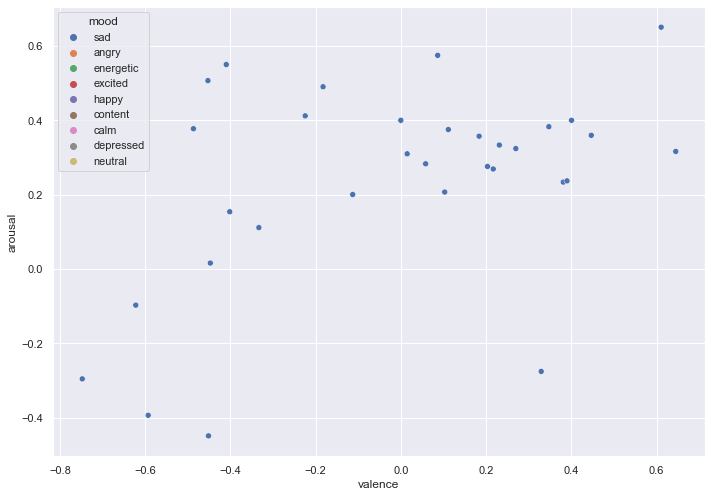

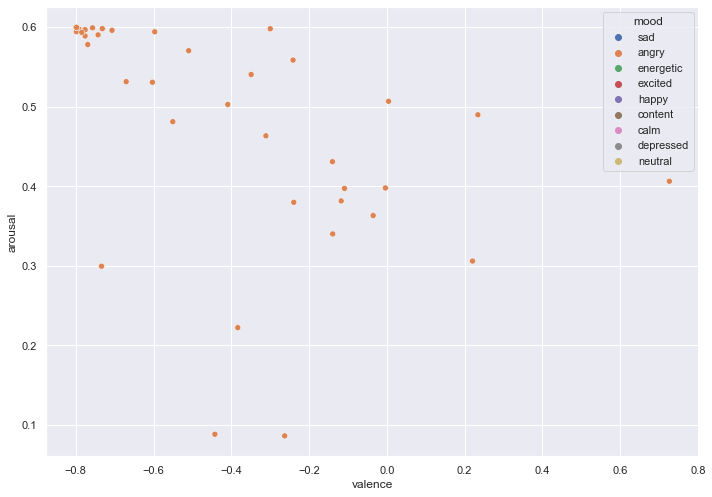

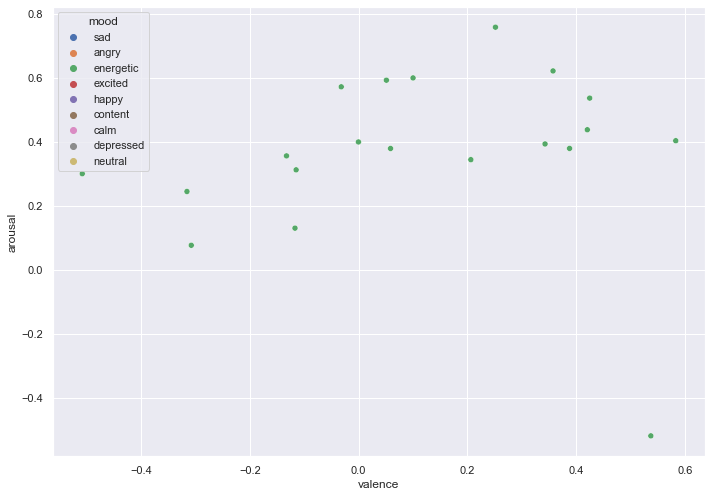

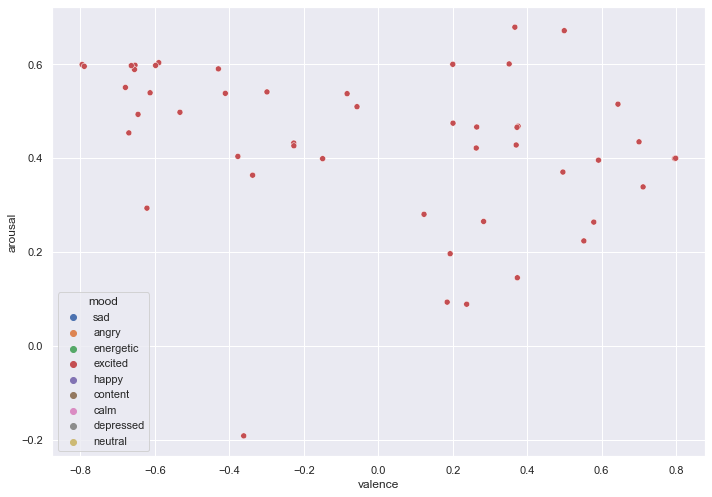

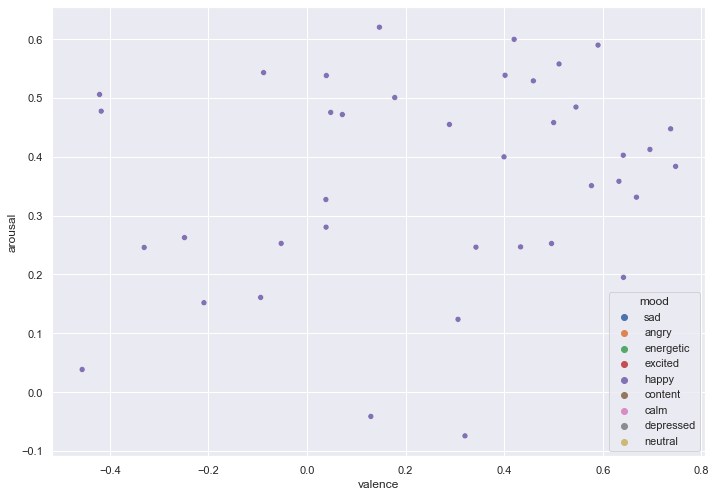

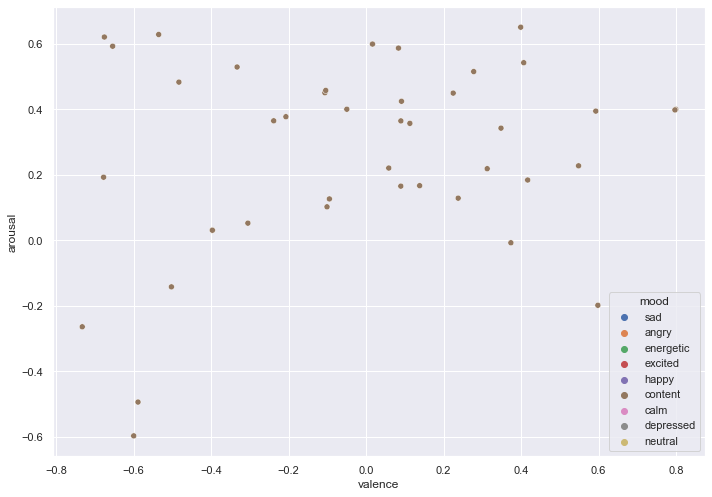

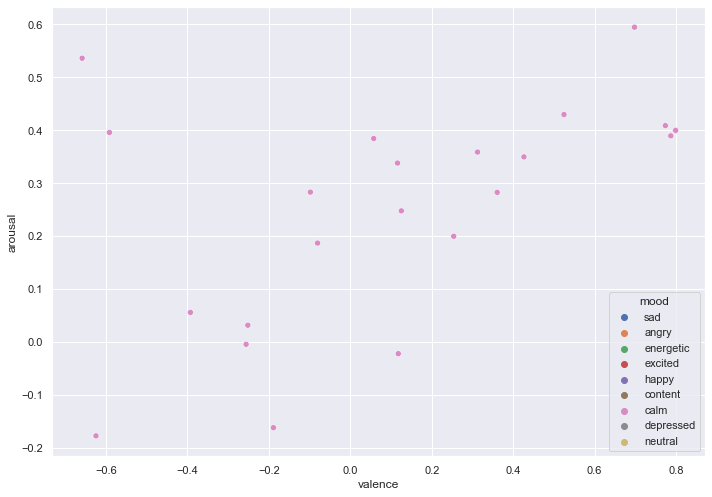

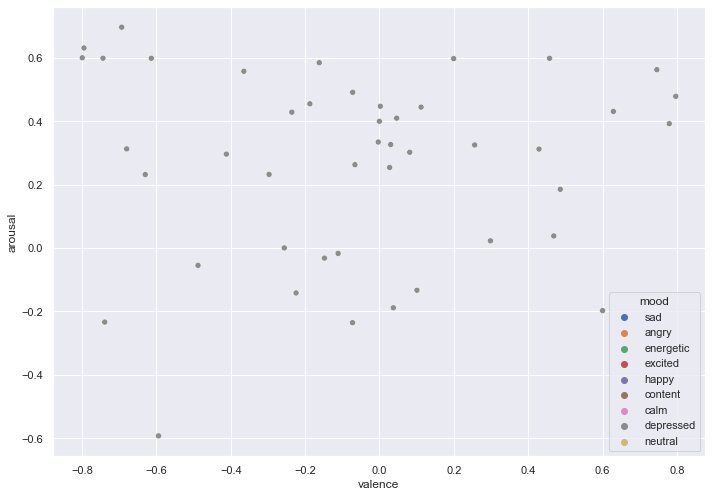

In [67]:
valid_sad=resultsDF[(resultsDF['mood']=='sad')&(resultsDF['relyOnLinear']==False)]
valid_angry=resultsDF[(resultsDF['mood']=='angry')&(resultsDF['relyOnLinear']==False)]
valid_energetic=resultsDF[(resultsDF['mood']=='energetic')&(resultsDF['relyOnLinear']==False)]
valid_excited=resultsDF[(resultsDF['mood']=='excited')&(resultsDF['relyOnLinear']==False)]
valid_happy=resultsDF[(resultsDF['mood']=='happy')&(resultsDF['relyOnLinear']==False)]
valid_content=resultsDF[(resultsDF['mood']=='content')&(resultsDF['relyOnLinear']==False)]
valid_calm=resultsDF[(resultsDF['mood']=='calm')&(resultsDF['relyOnLinear']==False)]
valid_depressed=resultsDF[(resultsDF['mood']=='depressed')&(resultsDF['relyOnLinear']==False)]

#get the valid results for each mood
#valid_angry_angry = valid_angry[valid_angry['predictionGPT_Copilot']=='angry']

#plot the valence and arousal scores for each mood on a separate graph
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence", y="arousal", hue="mood", data=valid_sad)
plt.show()

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence", y="arousal", hue="mood", data=valid_angry)
plt.show()

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence", y="arousal", hue="mood", data=valid_energetic)
plt.show()

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence", y="arousal", hue="mood", data=valid_excited)
plt.show()

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence", y="arousal", hue="mood", data=valid_happy)
plt.show()

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence", y="arousal", hue="mood", data=valid_content)
plt.show()

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence", y="arousal", hue="mood", data=valid_calm)
plt.show()

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence", y="arousal", hue="mood", data=valid_depressed)
plt.show()




In [66]:
valid_sad.describe()

,valence,arousal
count,33.000000,33.000000
mean,-0.013060,0.242314
std,0.380395,0.271061
min,-0.747377,-0.448819
25%,-0.401297,0.200389
50%,0.058256,0.316184
75%,0.269894,0.399880
max,0.645146,0.650457


In [89]:
emotionsAsValenceArousal= { 'admiration':(.6,.4),'amusement':(.6,.2),'anger':(-.8,.6),'annoyance':(-.6,.6),'approval':(.8,.6),'caring':(.6,-.2),'confusion':(-.2,.2),'curiosity':(0,.4),'desire':(.6,.6),'disappointment':(-.6,-.6),'disapproval':(-.8,.65),'disgust':(-.8,.2),'embarrassment':(-.6,.4),'excitement':(.6,.8),'fear':(-.6,.8),'gratitude':(.6,-.6),'gratitude':(.6,-.6),'grief':(-.6,-.8),'joy':(.8,.2),'love':(.8,.4),'nervousness':(-.4,.6),'optimism':(.6,.2),'pride':(.6,.1),'realization':(.2,.2),'relief':(.4,-.4),'remorse':(-.6,-.4),'sadness':(-.8,-.2),'surprise':(.2,.6),'neutral':(0,0)}
# sum all the values and divide by the total to get the average valence and arousal from the emotionsAsValenceArousal dictionary
totalValence=0
totalArousal=0
for key in emotionsAsValenceArousal:
    totalValence+=emotionsAsValenceArousal[key][0]
    totalArousal+=emotionsAsValenceArousal[key][1]
averageValence=totalValence/len(emotionsAsValenceArousal)
averageArousal=totalArousal/len(emotionsAsValenceArousal)
print("average valence:",averageValence)
print("average arousal:",averageArousal)

average valence: 0.021428571428571415
average arousal: 0.1982142857142857


In [69]:
resultsDF[resultsDF['relyOnLinear']==True].describe()

,valence,arousal
count,50.000000,50.000000
mean,-0.004828,0.007720
std,0.038357,0.036519
min,-0.231994,-0.160421
25%,-0.000013,0.000000
50%,0.000000,0.000000
75%,0.000002,0.002174
max,0.069861,0.095975


In [70]:
resultsDF[resultsDF['relyOnLinear']==False].describe()

,valence,arousal
count,293.000000,293.000000
mean,-0.029403,0.341806
std,0.456733,0.247234
min,-0.799680,-0.597821
25%,-0.408923,0.237097
50%,0.000052,0.397648
75%,0.348141,0.535811
max,0.799188,0.758264


In [73]:
BERT_model = AutoModelForSequenceClassification.from_pretrained("monologg/bert-base-cased-goemotions-original")
 


In [74]:
emotion_dict = BERT_model.config.id2label
emotion_dict

{0: 'admiration',
 1: 'amusement',
 10: 'disapproval',
 11: 'disgust',
 12: 'embarrassment',
 13: 'excitement',
 14: 'fear',
 15: 'gratitude',
 16: 'grief',
 17: 'joy',
 18: 'love',
 19: 'nervousness',
 2: 'anger',
 20: 'optimism',
 21: 'pride',
 22: 'realization',
 23: 'relief',
 24: 'remorse',
 25: 'sadness',
 26: 'surprise',
 27: 'neutral',
 3: 'annoyance',
 4: 'approval',
 5: 'caring',
 6: 'confusion',
 7: 'curiosity',
 8: 'desire',
 9: 'disappointment'}

In [86]:
emotionsAsValenceArousal= { 'admiration':(.6,.4),'amusement':(.6,.2),'anger':(-.8,.6),'annoyance':(-.6,.6),'approval':(.8,.6),'caring':(.6,-.2),'confusion':(-.2,.2),'curiosity':(0,.4),'desire':(.6,.6),'disappointment':(-.6,-.6),'disapproval':(-.8,.65),'disgust':(-.8,.2),'embarrassment':(-.6,.4),'excitement':(.6,.8),'fear':(-.6,.8),'gratitude':(.6,-.6),'gratitude':(.6,-.6),'grief':(-.6,-.8),'joy':(.8,.2),'love':(.8,.4),'nervousness':(-.4,.6),'optimism':(.6,.2),'pride':(.6,.1),'realization':(.2,.2),'relief':(.4,-.4),'remorse':(-.6,-.4),'sadness':(-.8,-.2),'surprise':(.2,.6),'neutral':(0,0)}


In [87]:
# find duplicate keys in the emotion_dict and emotionsAsValenceArousal dictionaries
duplicate_keys = set(emotion_dict.values()) & set(emotionsAsValenceArousal.keys())
print(duplicate_keys)

# find the keys in the emotion_dict that are not in the emotionsAsValenceArousal dictionary
missing_keys =  set(emotionsAsValenceArousal.keys()) - set(emotion_dict.values())
print(missing_keys)

{'nervousness', 'excitement', 'love', 'remorse', 'desire', 'surprise', 'relief', 'optimism', 'realization', 'pride', 'gratitude', 'approval', 'embarrassment', 'disgust', 'confusion', 'curiosity', 'amusement', 'disapproval', 'caring', 'disappointment', 'annoyance', 'fear', 'anger', 'grief', 'joy', 'sadness', 'neutral', 'admiration'}
set()


# removing bias

In [97]:
#subtract averageValence and averageArousal from the valence and arousal values in the valid_results dataframe
valid_resultsDF['valence_decreased'] = valid_resultsDF['valence'] - averageValence
valid_resultsDF['arousal_decreased'] = valid_resultsDF['arousal'] - averageArousal

<ipython-input-97-7a3695e924ee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_resultsDF['valence_decreased'] = valid_resultsDF['valence'] - averageValence
<ipython-input-97-7a3695e924ee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_resultsDF['arousal_decreased'] = valid_resultsDF['arousal'] - averageArousal


In [98]:
valid_resultsDF.describe()

,valence,arousal,valence_decreased,arousal_decreased
count,293.000000,293.000000,293.000000,293.000000
mean,-0.029403,0.341806,-0.050832,0.143592
std,0.456733,0.247234,0.456733,0.247234
min,-0.799680,-0.597821,-0.821108,-0.796035
25%,-0.408923,0.237097,-0.430352,0.038883
50%,0.000052,0.397648,-0.021376,0.199434
75%,0.348141,0.535811,0.326713,0.337597
max,0.799188,0.758264,0.777760,0.560050


# Threshold weight adjustment (new results using weight with both original version and threshold change 1)

In [118]:
valid_resultsDF['prediction2_norm'] = valid_resultsDF.apply(lambda x: determineMoodLabel(x['valence'],x['arousal']),axis=1)

<ipython-input-118-95ea7c45b8a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_resultsDF['prediction2_norm'] = valid_resultsDF.apply(lambda x: determineMoodLabel(x['valence'],x['arousal']),axis=1)


In [107]:
valid_resultsDF['predictionGPT2_norm'] = valid_resultsDF.apply(lambda x: determineMoodLabel2(x['valence'],x['arousal']),axis=1)

<ipython-input-107-5ca54c067e71>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_resultsDF['predictionGPT2_norm'] = valid_resultsDF.apply(lambda x: determineMoodLabel2(x['valence'],x['arousal']),axis=1)


## original version + weighted valence/arousal

In [119]:
valid_resultsDF.columns

Index(['mood', 'lyrics', 'id', 'prediction', 'valence', 'arousal',
       'relyOnLinear', 'correct', 'predictionGPT_Copilot', 'valence_decreased',
       'arousal_decreased', 'predictionGPT2_norm', 'prediction2_norm'],
      dtype='object')

In [123]:
getPrecision(valid_resultsDF,'prediction2_norm')

sad 0.15789473684210525
angry 0.3163265306122449
energetic 0.14285714285714285
excited 0.1728395061728395
happy 0.29411764705882354
content 0.125
calm 0
depressed 0.5454545454545454
avergae precision: 0.21931126362471268


In [120]:
getRecall(valid_resultsDF,'prediction2_norm')

sad 0.09090909090909091
angry 0.7380952380952381
energetic 0.3
excited 0.2857142857142857
happy 0.2564102564102564
content 0.023809523809523808
calm 0.0
depressed 0.13333333333333333
avergae recall: 0.22853396603396603


## threshold change 1 + weighted valence/arousal

In [124]:
getPrecision(valid_resultsDF,'predictionGPT2_norm')

sad 0.25
angry 0.3373493975903614
energetic 0.1346153846153846
excited 0.2247191011235955
happy 0.2857142857142857
content 0.0
calm 0.18518518518518517
depressed 0.25
avergae precision: 0.20844791927860154


In [125]:
getRecall(valid_resultsDF,'predictionGPT2_norm')

sad 0.12121212121212122
angry 0.6666666666666666
energetic 0.35
excited 0.40816326530612246
happy 0.15384615384615385
content 0.0
calm 0.21739130434782608
depressed 0.022222222222222223
avergae recall: 0.24243771670013903


# Replotting Results (this time weighted scores broken down by true labels AND Pred labels)

In [126]:
valid_resultsDF.columns

Index(['mood', 'lyrics', 'id', 'prediction', 'valence', 'arousal',
       'relyOnLinear', 'correct', 'predictionGPT_Copilot', 'valence_decreased',
       'arousal_decreased', 'predictionGPT2_norm', 'prediction2_norm'],
      dtype='object')

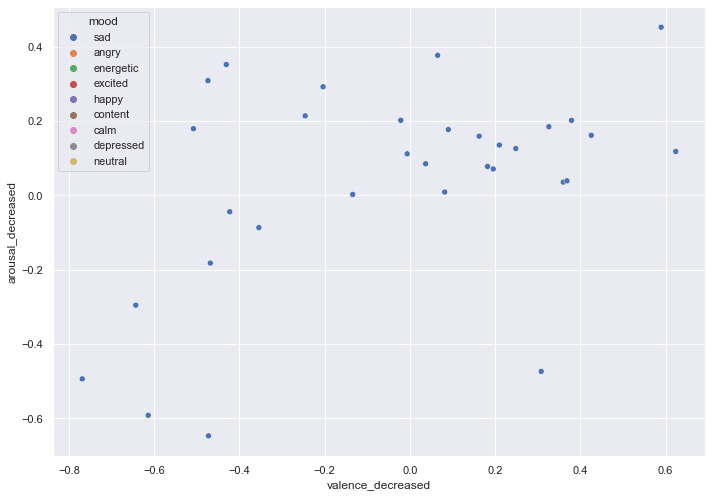

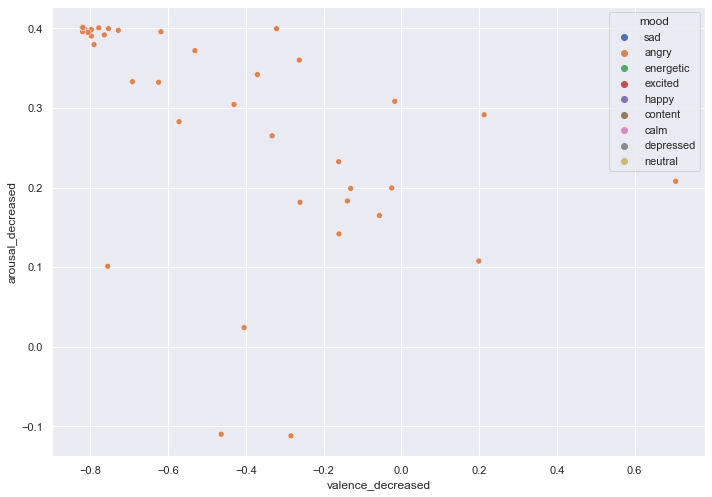

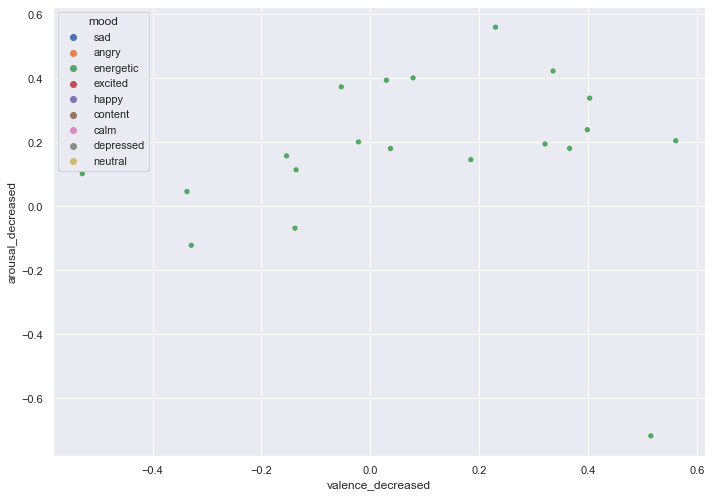

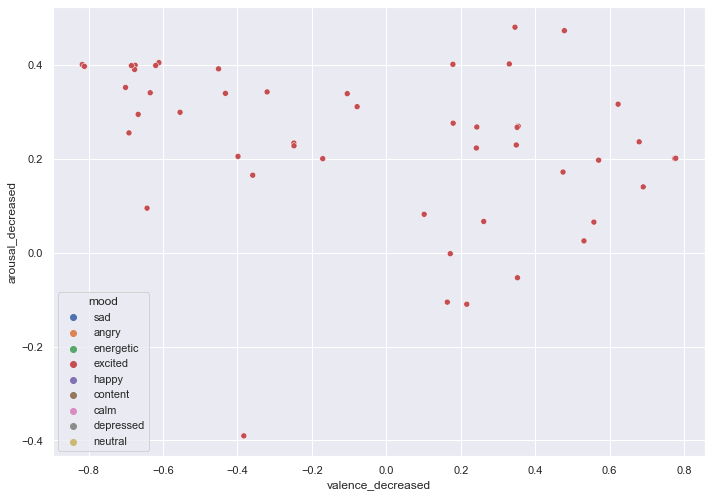

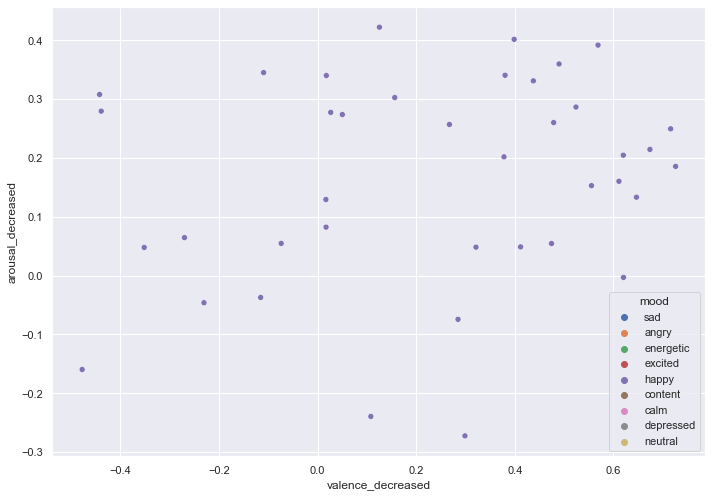

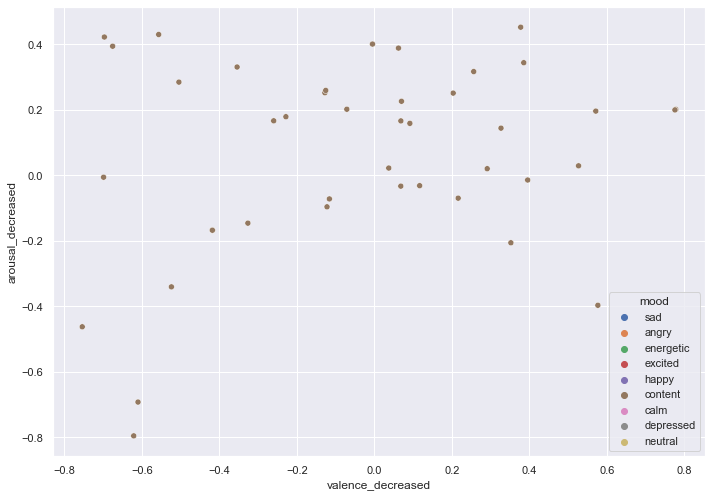

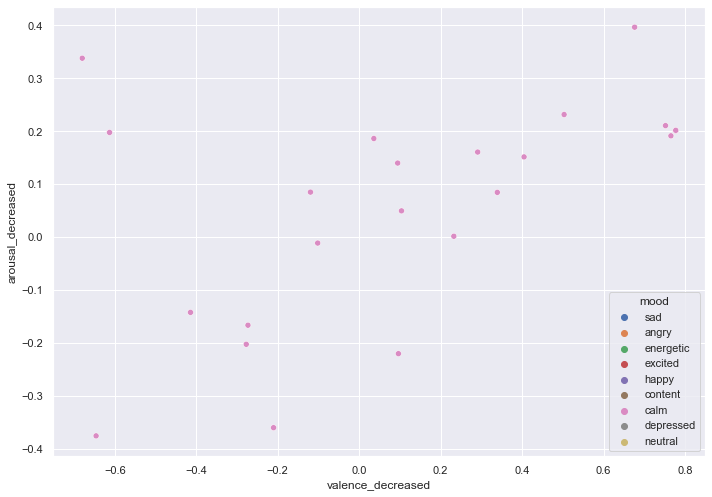

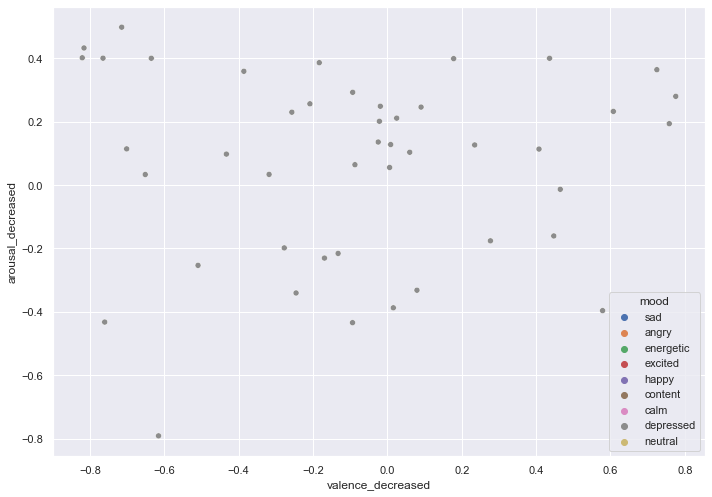

In [129]:
valid_sad=valid_resultsDF[(valid_resultsDF['mood']=='sad')&(valid_resultsDF['relyOnLinear']==False)]
valid_angry=valid_resultsDF[(valid_resultsDF['mood']=='angry')&(valid_resultsDF['relyOnLinear']==False)]
valid_energetic=valid_resultsDF[(valid_resultsDF['mood']=='energetic')&(valid_resultsDF['relyOnLinear']==False)]
valid_excited=valid_resultsDF[(valid_resultsDF['mood']=='excited')&(valid_resultsDF['relyOnLinear']==False)]
valid_happy=valid_resultsDF[(valid_resultsDF['mood']=='happy')&(valid_resultsDF['relyOnLinear']==False)]
valid_content=valid_resultsDF[(valid_resultsDF['mood']=='content')&(valid_resultsDF['relyOnLinear']==False)]
valid_calm=valid_resultsDF[(valid_resultsDF['mood']=='calm')&(valid_resultsDF['relyOnLinear']==False)]
valid_depressed=valid_resultsDF[(valid_resultsDF['mood']=='depressed')&(valid_resultsDF['relyOnLinear']==False)]

#get the valid results for each mood
#valid_angry_angry = valid_angry[valid_angry['predictionGPT_Copilot']=='angry']

#plot the valence_decreased and arousal_decreased scores for each mood on a separate graph
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence_decreased", y="arousal_decreased", hue="mood", data=valid_sad)
plt.show()

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence_decreased", y="arousal_decreased", hue="mood", data=valid_angry)
plt.show()

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence_decreased", y="arousal_decreased", hue="mood", data=valid_energetic)
plt.show()

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence_decreased", y="arousal_decreased", hue="mood", data=valid_excited)
plt.show()

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence_decreased", y="arousal_decreased", hue="mood", data=valid_happy)
plt.show()

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence_decreased", y="arousal_decreased", hue="mood", data=valid_content)
plt.show()

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence_decreased", y="arousal_decreased", hue="mood", data=valid_calm)
plt.show()

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence_decreased", y="arousal_decreased", hue="mood", data=valid_depressed)
plt.show()




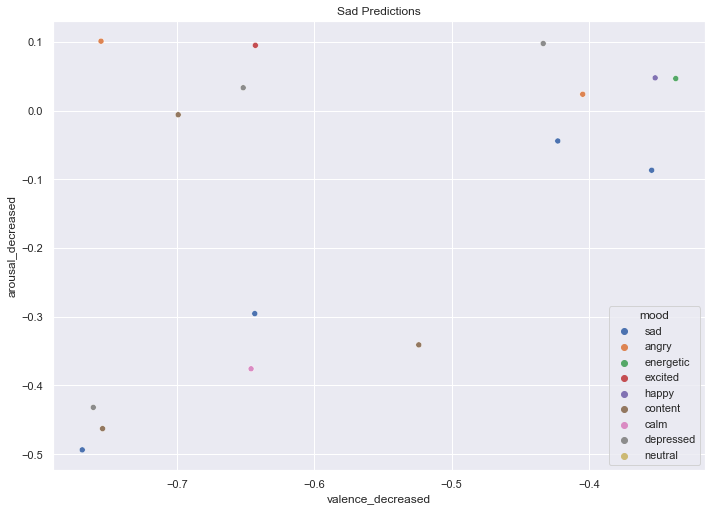

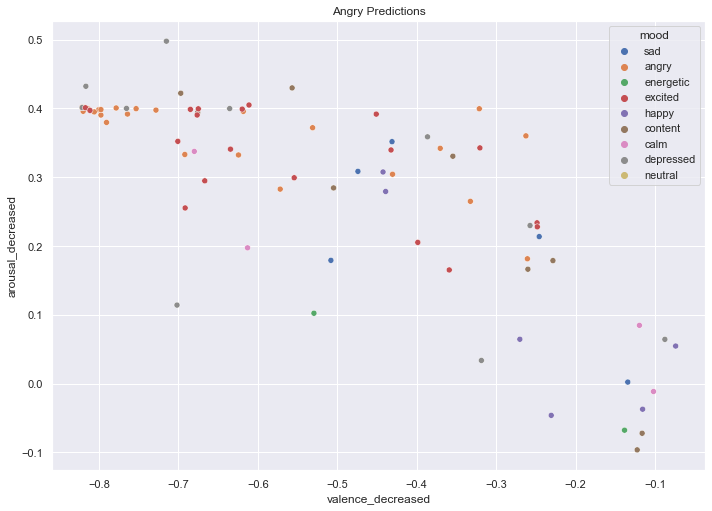

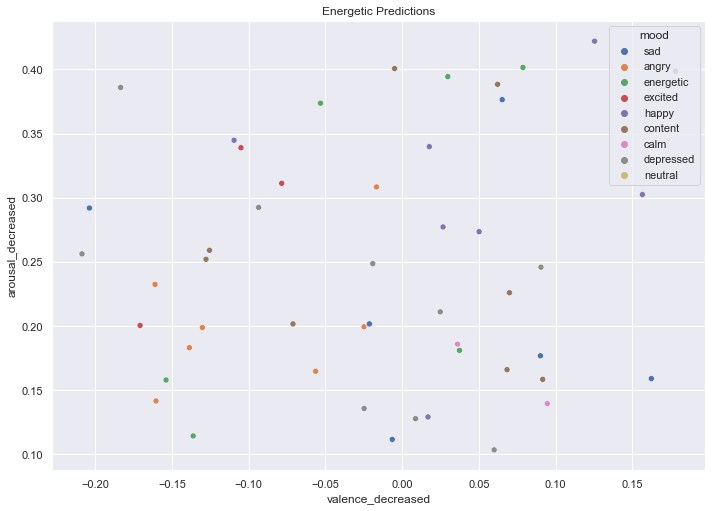

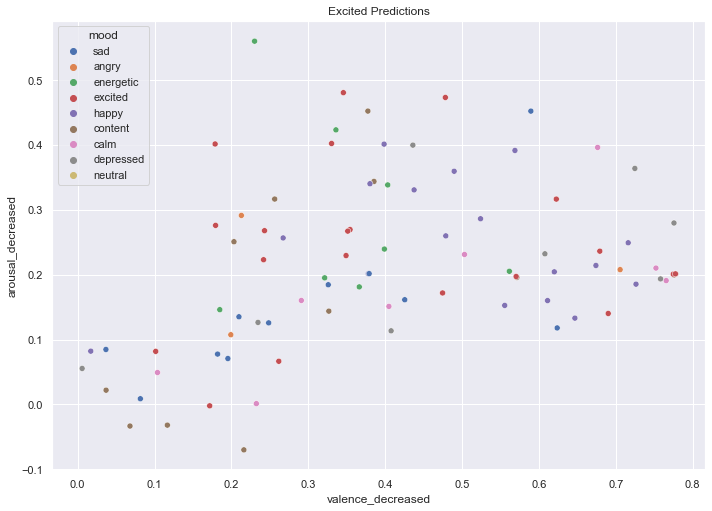

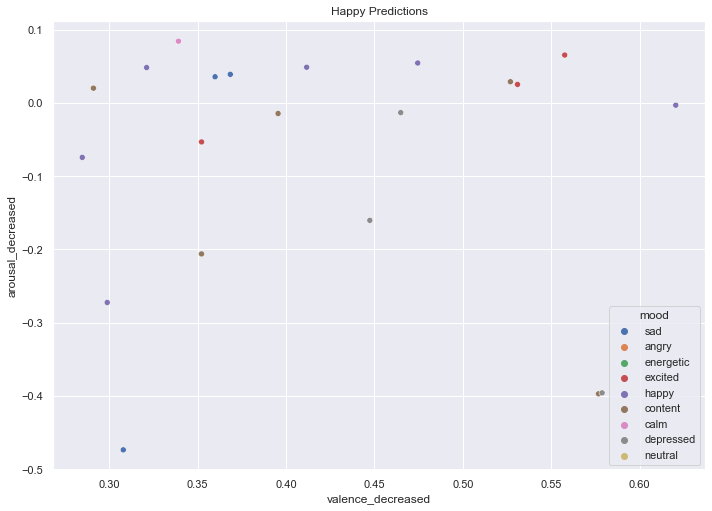

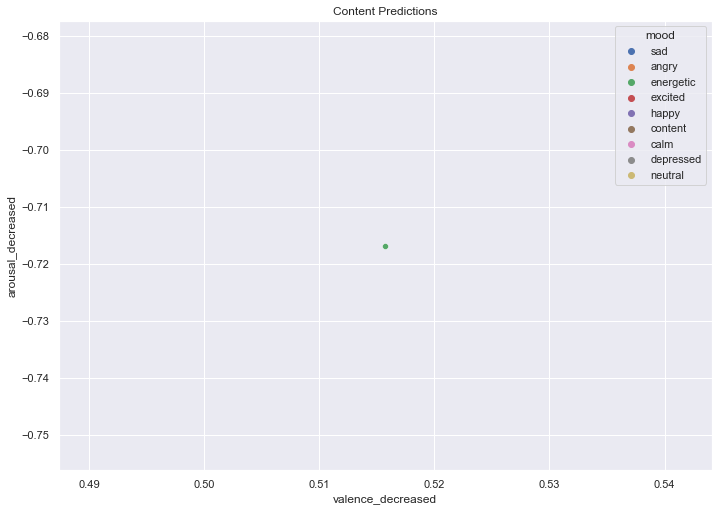

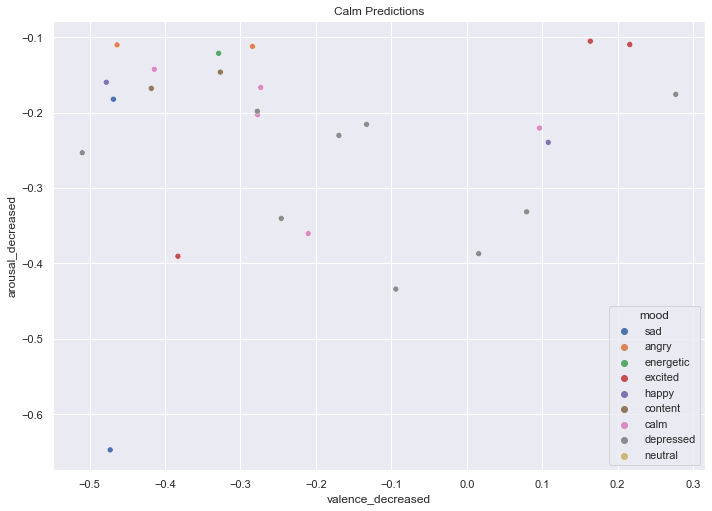

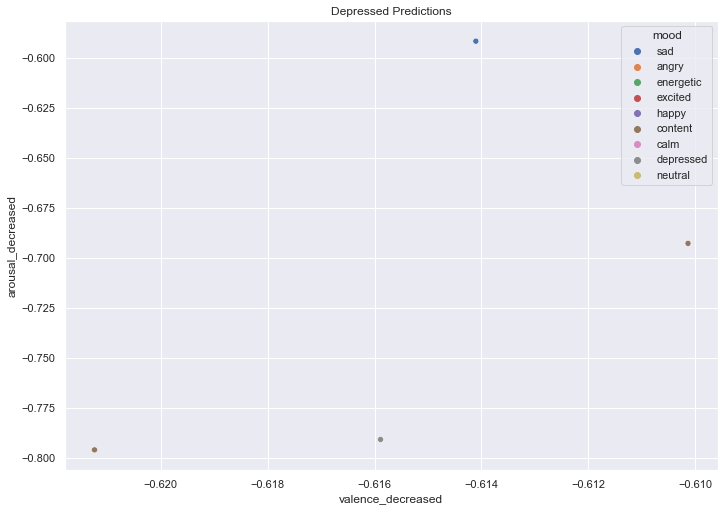

In [135]:
valid_sad=valid_resultsDF[(valid_resultsDF['predictionGPT2_norm']=='sad')]
valid_angry=valid_resultsDF[(valid_resultsDF['predictionGPT2_norm']=='angry')]
valid_energetic=valid_resultsDF[(valid_resultsDF['predictionGPT2_norm']=='energetic')]
valid_excited=valid_resultsDF[(valid_resultsDF['predictionGPT2_norm']=='excited')]
valid_happy=valid_resultsDF[(valid_resultsDF['predictionGPT2_norm']=='happy')]
valid_content=valid_resultsDF[(valid_resultsDF['predictionGPT2_norm']=='content')]
valid_calm=valid_resultsDF[(valid_resultsDF['predictionGPT2_norm']=='calm')]
valid_depressed=valid_resultsDF[(valid_resultsDF['predictionGPT2_norm']=='depressed')]

#get the valid results for each mood
#valid_angry_angry = valid_angry[valid_angry['predictionGPT_Copilot']=='angry']

#plot the valence_decreased and arousal_decreased scores for each mood on a separate graph
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence_decreased", y="arousal_decreased", hue="mood", data=valid_sad)
#add a title to the graph
plt.title('Sad Predictions')
plt.show()

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence_decreased", y="arousal_decreased", hue="mood", data=valid_angry)
plt.title('Angry Predictions')
plt.show()

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence_decreased", y="arousal_decreased", hue="mood", data=valid_energetic)
plt.title('Energetic Predictions')
plt.show()

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence_decreased", y="arousal_decreased", hue="mood", data=valid_excited)
plt.title('Excited Predictions')
plt.show()

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence_decreased", y="arousal_decreased", hue="mood", data=valid_happy)
plt.title('Happy Predictions')
plt.show()

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence_decreased", y="arousal_decreased", hue="mood", data=valid_content)
plt.title('Content Predictions')
plt.show()

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence_decreased", y="arousal_decreased", hue="mood", data=valid_calm)
plt.title('Calm Predictions')
plt.show()

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence_decreased", y="arousal_decreased", hue="mood", data=valid_depressed)
plt.title('Depressed Predictions')
plt.show()




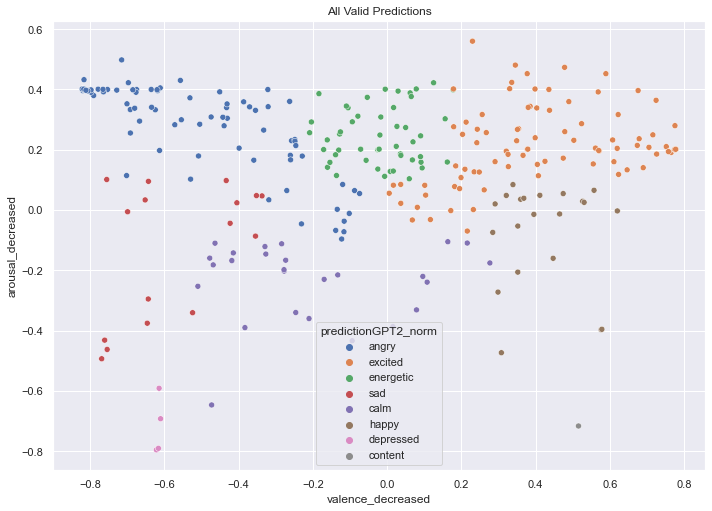

In [136]:
#plot all the valid results on one graph
sns.set(style="whitegrid")

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence_decreased", y="arousal_decreased",hue="predictionGPT2_norm", data=valid_resultsDF)
plt.title('All Valid Predictions')
plt.show()

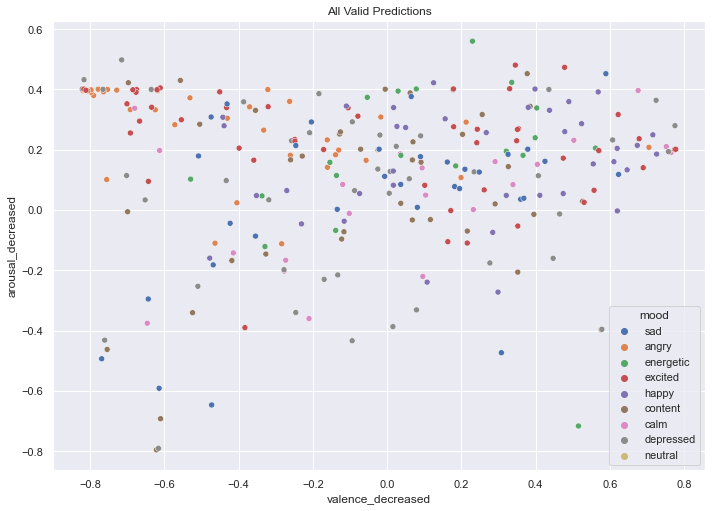

In [137]:
#plot all the valid results on one graph
sns.set(style="whitegrid")

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence_decreased", y="arousal_decreased",hue="mood", data=valid_resultsDF)
plt.title('All Valid Predictions')
plt.show()

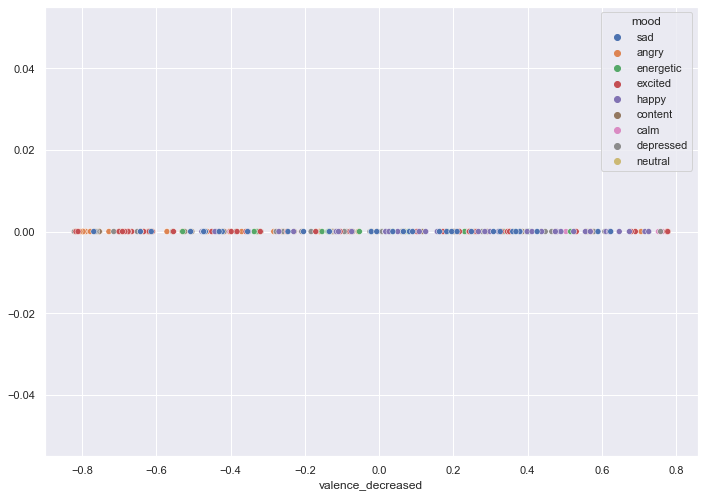

In [139]:
#just plot valence
sns.set(style="whitegrid")

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="valence_decreased",y=0,hue="mood", data=valid_resultsDF)
plt.show()

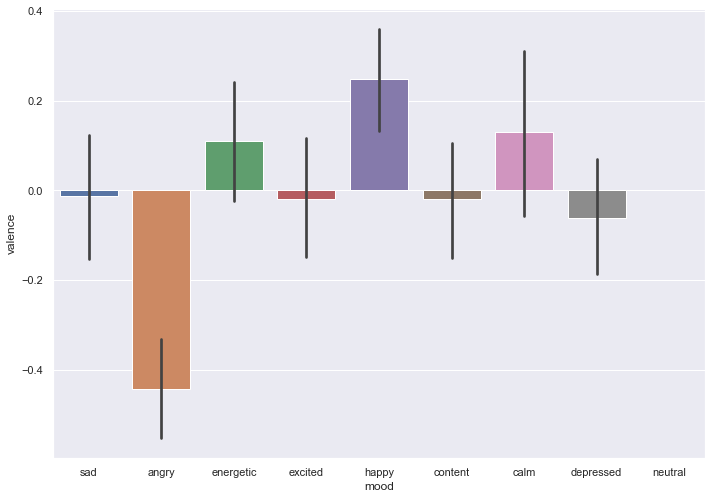

In [143]:
#plot a bar graph of the distribution of valence_decreased scores
sns.set(style="whitegrid")

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="mood", y="valence", data=valid_resultsDF)
plt.show()

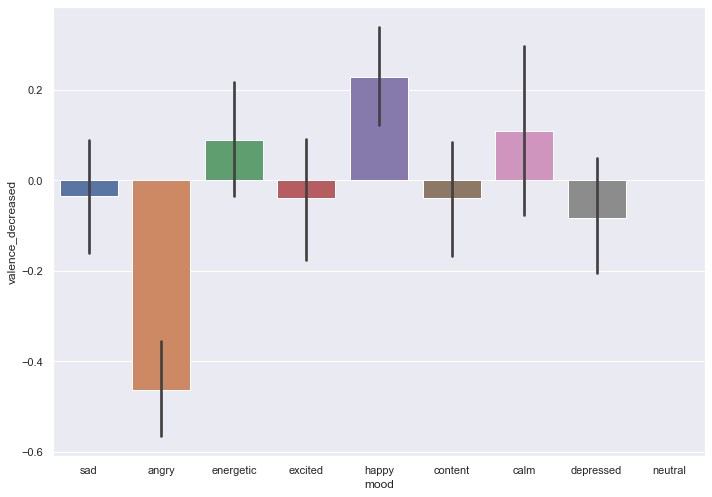

In [144]:
#plot a bar graph of the distribution of valence_decreased scores
sns.set(style="whitegrid")

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="mood", y="valence_decreased", data=valid_resultsDF)
plt.show()

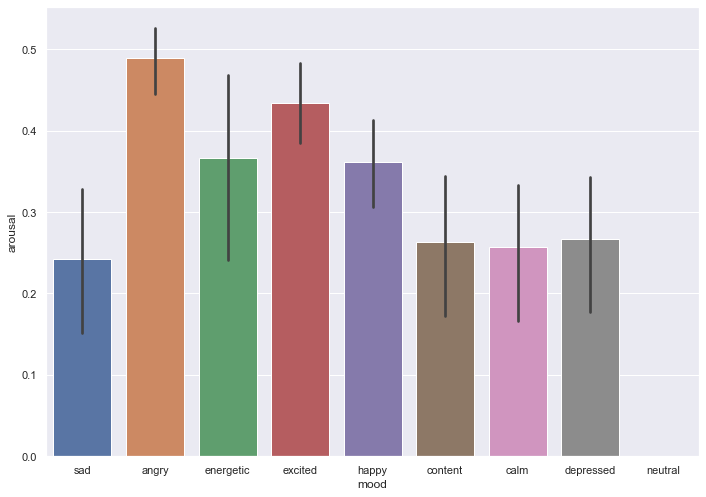

In [145]:
#plot a bar graph of the distribution of valence_decreased scores
sns.set(style="whitegrid")

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="mood", y="arousal", data=valid_resultsDF)
plt.show()

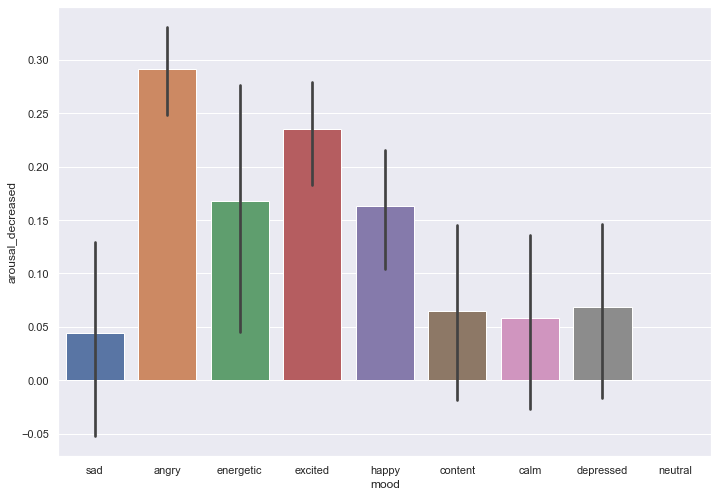

In [146]:
#plot a bar graph of the distribution of valence_decreased scores
sns.set(style="whitegrid")

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="mood", y="arousal_decreased", data=valid_resultsDF)
plt.show()

In [148]:
chdir('C:/Users/mlar5/OneDrive/Desktop/Code Folder/Python Projects/IRL projects/Aspire - Affective Computing Project/Playlists Data/Audio Features/emotion joint data')
emotionsDF = pd.read_csv('Merged Emotions Data4.csv')
chdir('C:/Users/mlar5/OneDrive/Desktop/Code Folder/Python Projects/IRL projects/Aspire - Affective Computing Project/Playlists Data/Track Lyrics/')

In [168]:
categories = ['sad', 'angry', 'energetic', 'excited', 'happy', 'content','calm',  'depressed']
emotionsDF['mood'] = pd.Categorical(emotionsDF['mood'], categories=categories, ordered=True)


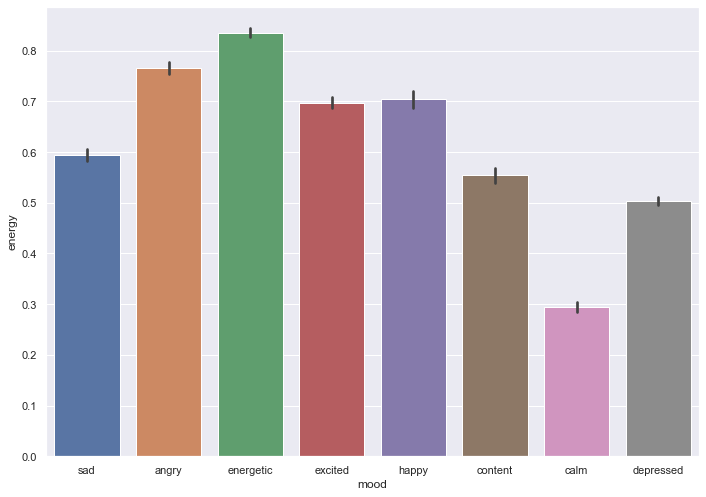

In [169]:
# do the same graph for the emotionsDF

#plot a bar graph of the distribution of valence_decreased scores
sns.set(style="whitegrid")

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="mood", y="energy", data=emotionsDF)
plt.show()

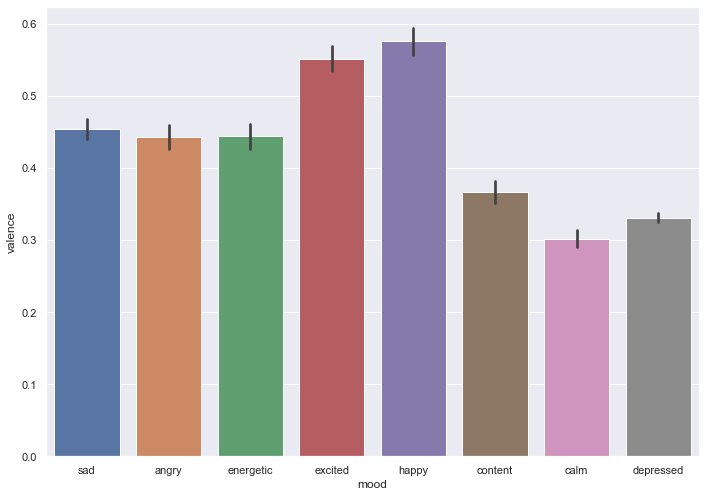

In [170]:
# do the same graph for the emotionsDF

#plot a bar graph of the distribution of valence_decreased scores
sns.set(style="whitegrid")

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="mood", y="valence", data=emotionsDF)
plt.show()

In [171]:
emotionsDF.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,9314.000000,9314.000000,9314.000000,9314.000000,9314.000000,9314.000000,9314.000000,9314.000000,9314.000000,9314.000000,9314.000000,9314.000000,9314.000000
mean,0.614817,0.557765,5.216770,-8.814532,0.611553,0.102964,0.351742,0.187254,0.172879,0.388826,121.377905,192732.916362,3.937084
std,0.150066,0.255412,3.577993,5.399209,0.487423,0.108850,0.343627,0.345488,0.131017,0.226781,30.404599,58521.438423,0.357631
min,0.000000,0.002760,0.000000,-38.986000,0.000000,0.000000,0.000003,0.000000,0.015000,0.000000,0.000000,33787.000000,0.000000
25%,0.517000,0.366000,2.000000,-10.990000,0.000000,0.036600,0.039000,0.000000,0.099225,0.205250,96.016000,150864.750000,4.000000
50%,0.626000,0.584000,5.000000,-7.270000,1.000000,0.054100,0.214000,0.000026,0.118000,0.358000,122.030500,191840.000000,4.000000
75%,0.725000,0.766000,8.000000,-5.089000,1.000000,0.118000,0.670000,0.090400,0.196000,0.544000,142.590500,225356.500000,4.000000
max,0.975000,0.998000,11.000000,3.639000,1.000000,0.891000,0.996000,0.986000,0.970000,0.979000,214.413000,733208.000000,5.000000


In [172]:
#get the mean of the valence and arousal scores for each mood in emotionsDF
emotionsDF.groupby('mood').describe()[['valence','energy']]

valence                                                        \
            count      mean       std     min      25%     50%      75%   
mood                                                                      
sad        1020.0  0.453495  0.224098  0.0364  0.27400  0.4250  0.62300   
angry       694.0  0.442843  0.226429  0.0353  0.26925  0.4325  0.60975   
energetic   631.0  0.443457  0.219937  0.0305  0.26550  0.4280  0.61600   
excited     678.0  0.551186  0.235248  0.0385  0.37800  0.5515  0.74975   
happy       519.0  0.575481  0.219076  0.0389  0.39300  0.5840  0.75100   
content     773.0  0.366211  0.214307  0.0260  0.20500  0.3430  0.52200   
calm       1218.0  0.301832  0.198827  0.0347  0.14525  0.2620  0.41475   
depressed  3781.0  0.330260  0.198660  0.0000  0.17000  0.3030  0.46000   

                  energy                                                \
             max   count      mean       std      min      25%     50%   
mood                                                                     
sad        0.974  1020.0  0.594574  0.198559  0.01000  0.44475  0.6210   
angry      0.974   694.0  0.765411  0.156508  0.22000  0.66150  0.7915   
energetic  0.963   631.0  0.835288  0.121720  0.12500  0.77850  0.8660   
excited    0.979   678.0  0.697670  0.146531  0.10500  0.59125  0.7065   
happy      0.967   519.0  0.704942  0.191398  0.04400  0.62750  0.7440   
content    0.961   773.0  0.554066  0.197480  0.00558  0.41700  0.5590   
calm       0.969  1218.0  0.295174  0.181766  0.00276  0.15325  0.2710   
depressed  0.963  3781.0  0.503464  0.250746  0.00312  0.30500  0.5180   

                          
              75%    max  
mood                      
sad        0.7510  0.993  
angry      0.8950  0.998  
energetic  0.9235  0.998  
excited    0.8215  0.989  
happy      0.8320  0.983  
content    0.7060  0.989  
calm       0.4120  0.927  
depressed  0.6890  0.998

# simple classifier testing

In [260]:
def offByOne(y_test_standard, y_pred,digits=3):
    #compare y_test_standard with y_pred_list. If y_pred_list is +-1 from y_test_standard, then it change it to be the same as y_test_standard
    y_test_standard_list=list(y_test_standard)
    y_pred_list = list(y_pred)
    for id in range(len(y_test_standard_list)):
        if y_test_standard_list[id] != 0 and y_test_standard_list[id] != 7:
            if y_pred_list[id] == y_test_standard_list[id] - 1 or y_pred_list[id] == y_test_standard_list[id] + 1:
                y_pred_list[id] = y_test_standard_list[id]
        elif y_test_standard_list[id] == 0:
            if y_pred_list[id] ==  1 or y_pred_list[id] == 7:
                y_pred_list[id] = y_test_standard_list[id]
        elif y_test_standard_list[id] == 7:
            if y_pred_list[id] ==  0 or y_pred_list[id] == 6:
                y_pred_list[id] = y_test_standard_list[id]
    print(classification_report(y_test_standard_list, y_pred_list,digits = digits))
    return

In [311]:
#make a classifier for the emotionsDF, which only takes in valence and energy, and outputs the mood
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
"""
X = emotionsDF[['valence','energy']]
y = emotionsDF['mood']
"""
#only take an even number of each mood
# create a new df with only up to 500 songs per mood
# this is to balance the data

balancedDF = pd.DataFrame(columns=emotionsDF.columns)

for i in emotionsDF['mood'].unique():
    df = emotionsDF[emotionsDF['mood']==i]
    #if the value count of the mood is larger than 500, sample 500
    if df['mood'].value_counts()[i] > 600:
        df = df.sample(n=600, random_state=42)
    #if the value count of the mood is less than 500, sample the value count
    else:
        df = df.sample(n=df['mood'].value_counts()[i])
    balancedDF = pd.concat([balancedDF, df])

balancedDF['mood'].value_counts()

X = balancedDF[['valence','energy']]
y = balancedDF['mood'].cat.codes

In [319]:

unbalancedDF = emotionsDF[~emotionsDF.index.isin(balancedDF.index)]
extra_test_x = unbalancedDF[['valence','energy']]
extra_test_x = 
extra_test_y = unbalancedDF['mood'].cat.codes


In [337]:
y

381     1
666     1
257     1
338     1
319     1
       ..
8614    0
8313    0
9120    0
9100    0
9119    0
Length: 4719, dtype: int8

In [314]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

logreg = LogisticRegression(random_state=0)#, solver='lbfgs', multi_class='multinomial')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

#get the f-1 score for the classifier
from sklearn.metrics import f1_score

#print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred,digits = 3))

Accuracy of logistic regression classifier on test set: 0.30
              precision    recall  f1-score   support

           0      0.107     0.080     0.091       113
           1      0.192     0.106     0.137       132
           2      0.356     0.691     0.470       123
           3      0.261     0.345     0.297       119
           4      0.462     0.058     0.103       104
           5      0.270     0.081     0.124       124
           6      0.468     0.802     0.591       111
           7      0.205     0.263     0.230       118

    accuracy                          0.302       944
   macro avg      0.290     0.303     0.255       944
weighted avg      0.286     0.302     0.255       944



In [316]:
offByOne(y_test, y_pred)

              precision    recall  f1-score   support

           0      0.463     0.389     0.423       113
           1      0.654     0.644     0.649       132
           2      0.583     0.829     0.685       123
           3      0.496     0.555     0.524       119
           4      0.958     0.442     0.605       104
           5      0.631     0.331     0.434       124
           6      0.750     0.865     0.803       111
           7      0.488     0.703     0.576       118

    accuracy                          0.596       944
   macro avg      0.628     0.595     0.587       944
weighted avg      0.623     0.596     0.587       944



In [341]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#combine the test set with the extra test set
X_test = pd.concat([X_test, extra_test_x])
y_test = pd.concat([y_test, extra_test_y])

logreg = LogisticRegression(random_state=0)#, solver='lbfgs', multi_class='multinomial')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

#get the f-1 score for the classifier
from sklearn.metrics import f1_score

#print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred,digits = 3))

Accuracy of logistic regression classifier on test set: 0.27
              precision    recall  f1-score   support

           0      0.107     0.101     0.104       533
           1      0.074     0.106     0.087       226
           2      0.124     0.662     0.209       154
           3      0.105     0.330     0.160       197
           4      0.094     0.058     0.071       104
           5      0.079     0.074     0.077       297
           6      0.289     0.757     0.418       729
           7      0.673     0.207     0.316      3299

    accuracy                          0.272      5539
   macro avg      0.193     0.287     0.180      5539
weighted avg      0.465     0.272     0.274      5539



In [342]:
offByOne(y_test, y_pred)

              precision    recall  f1-score   support

           0      0.613     0.351     0.446       533
           1      0.362     0.650     0.465       226
           2      0.179     0.825     0.295       154
           3      0.182     0.563     0.275       197
           4      0.511     0.442     0.474       104
           5      0.278     0.316     0.296       297
           6      0.826     0.874     0.849       729
           7      0.932     0.653     0.768      3299

    accuracy                          0.633      5539
   macro avg      0.486     0.584     0.484      5539
weighted avg      0.774     0.633     0.674      5539



In [264]:
# try classifying with a random forest classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print('Accuracy of random forest classifier on test set: {:.2f}'.format(rf.score(X_test, y_test)))

# get the f-1 score for the random forest classifier
f1_score(y_test, y_pred, average='weighted')

Accuracy of random forest classifier on test set: 0.23


0.22782767045640295

In [265]:
offByOne(y_test, y_pred)

              precision    recall  f1-score   support

           0      0.333     0.363     0.347       113
           1      0.571     0.515     0.542       132
           2      0.638     0.675     0.656       123
           3      0.533     0.471     0.500       119
           4      0.553     0.500     0.525       104
           5      0.392     0.411     0.402       124
           6      0.672     0.757     0.712       111
           7      0.534     0.534     0.534       118

    accuracy                          0.528       944
   macro avg      0.528     0.528     0.527       944
weighted avg      0.528     0.528     0.527       944



# Splitting into 2 problems

## route 1: break up into 2 low to high problems (in terms of valence)

In [183]:
# create subBalancedDF1, which is a subset of balancedDF, which only includes 4 moods: sad, angry, energetic, and excited
subBalancedDF1 = balancedDF[balancedDF['mood'].isin(['sad', 'angry', 'energetic', 'excited'])]
# create subBalancedDF2, which is a subset of balancedDF, which only includes 4 moods: happy, content, calm, and depressed
subBalancedDF2 = balancedDF[balancedDF['mood'].isin(['happy', 'content', 'calm', 'depressed'])]


In [266]:
categories2 = ['happy', 'content','calm',  'depressed']
subBalancedDF2['mood'] = pd.Categorical(subBalancedDF2['mood'], categories=categories2, ordered=True)

<ipython-input-266-f4ccd8094112>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subBalancedDF2['mood'] = pd.Categorical(subBalancedDF2['mood'], categories=categories2, ordered=True)


### linear regression

In [267]:
# make a classifier for subBalancedDF1, which only takes in valence and energy, and outputs the mood
X = subBalancedDF1[['valence','energy']]
y = subBalancedDF1['mood'].cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

logreg = LogisticRegression(random_state=0)#, solver='lbfgs', multi_class='multinomial')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

# get the f-1 score for the classifier
f1_score(y_test, y_pred, average='weighted')

Accuracy of logistic regression classifier on test set: 0.44


0.41754022741169994

In [269]:
offByOne(y_test, y_pred)

              precision    recall  f1-score   support

           0      0.617     0.640     0.628       111
           1      0.874     0.789     0.829       123
           2      0.881     0.952     0.915       125
           3      0.580     0.570     0.575       121

    accuracy                          0.742       480
   macro avg      0.738     0.738     0.737       480
weighted avg      0.742     0.742     0.741       480



In [273]:
# make a classifier for subBalancedDF1, which only takes in valence and energy, and outputs the mood
X2 = subBalancedDF2[['valence','energy']]
y2 = subBalancedDF2['mood'].cat.codes

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=0)

logreg2 = LogisticRegression(random_state=0)#, solver='lbfgs', multi_class='multinomial')
logreg2.fit(X_train2, y_train2)

y_pred2 = logreg2.predict(X_test2)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg2.score(X_test2, y_test2)))

# get the f-1 score for the classifier
f1_score(y_test2, y_pred2, average='weighted')

Accuracy of logistic regression classifier on test set: 0.43


0.40652073769597885

In [274]:
offByOne(y_test2, y_pred2)

              precision    recall  f1-score   support

           0      0.709     0.880     0.785        83
           1      0.706     0.597     0.647       129
           2      0.953     0.960     0.957       126
           3      0.552     0.548     0.550       126

    accuracy                          0.733       464
   macro avg      0.730     0.746     0.735       464
weighted avg      0.732     0.733     0.729       464



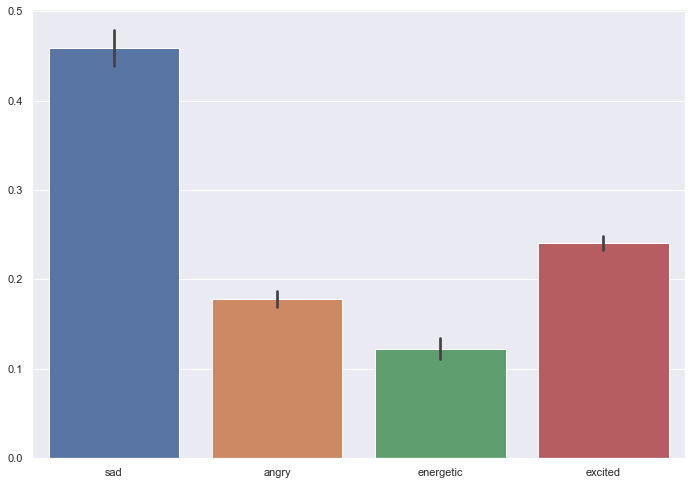

In [277]:
y_pred_prob2 = logreg.predict_proba(X_test2)

#get the probabilities averaged for each mood
probDF2 = pd.DataFrame(y_pred_prob2, columns = ['sad', 'angry', 'energetic', 'excited'])
sns.set(style="whitegrid")

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(data=probDF2)
plt.show()


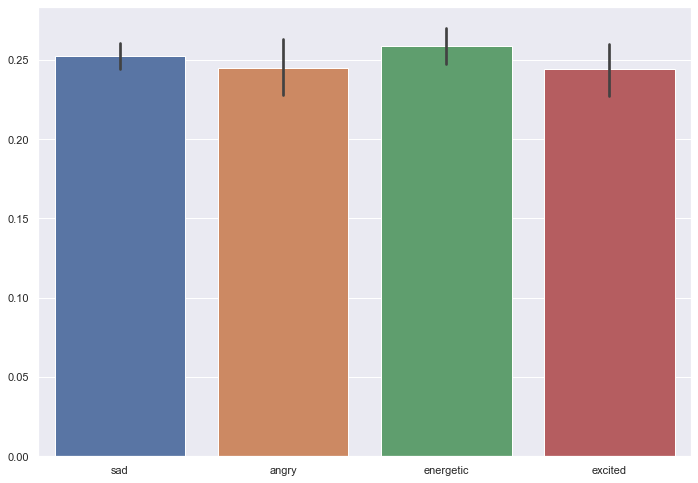

In [203]:
#get the probabilty of the predictions
y_pred_prob = logreg.predict_proba(X_test)

# get the probability of the predictions for the incorrect predictions and plot the distribution
incorrectPreds = y_pred_prob[y_pred != y_test]
#get the probability of the selected mood
incorrectPreds = incorrectPreds[:,[0,1,2,3]]
incorrectPredsDF = pd.DataFrame(incorrectPreds, columns=['sad', 'angry', 'energetic', 'excited'])
sns.set(style="whitegrid")

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(data=incorrectPredsDF)
plt.show()


In [204]:
incorrectPredsDF

,sad,angry,energetic,excited
0,0.186501,0.119508,0.401677,0.292314
1,0.095668,0.035431,0.444402,0.424499
2,0.306362,0.210276,0.215340,0.268023
3,0.312812,0.565077,0.073248,0.048863
4,0.209423,0.227702,0.403835,0.159040
...,...,...,...,...
264,0.338484,0.297083,0.175427,0.189006
265,0.243837,0.104182,0.217545,0.434436
266,0.291696,0.199815,0.236151,0.272338
267,0.298691,0.163902,0.198270,0.339136


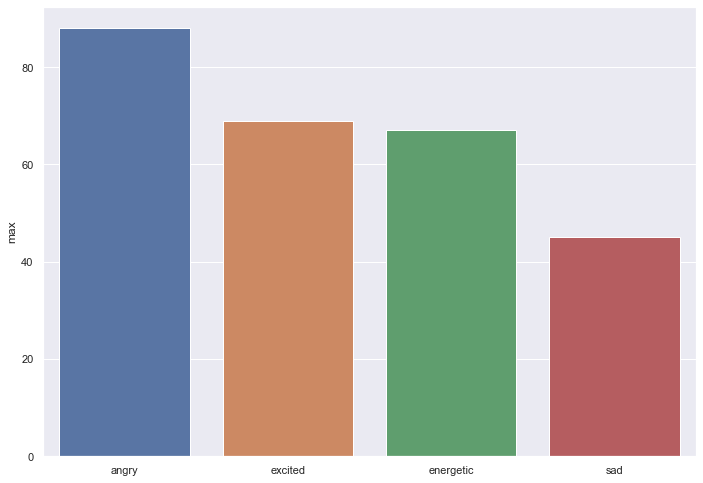

In [205]:
#convert the dtypes to work with argmax
incorrectPredsDF = incorrectPredsDF.astype('float64')
#get the argmax of the incorrect predictions
incorrectPredsDF['max'] = incorrectPredsDF.idxmax(axis=1)
#track the number of times each mood is predicted
incorrectPredsDF['max'].value_counts()
#plot the distribution of the incorrect predictions
sns.set(style="whitegrid")

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x=incorrectPredsDF['max'].value_counts().index, y=incorrectPredsDF['max'].value_counts())
plt.show()

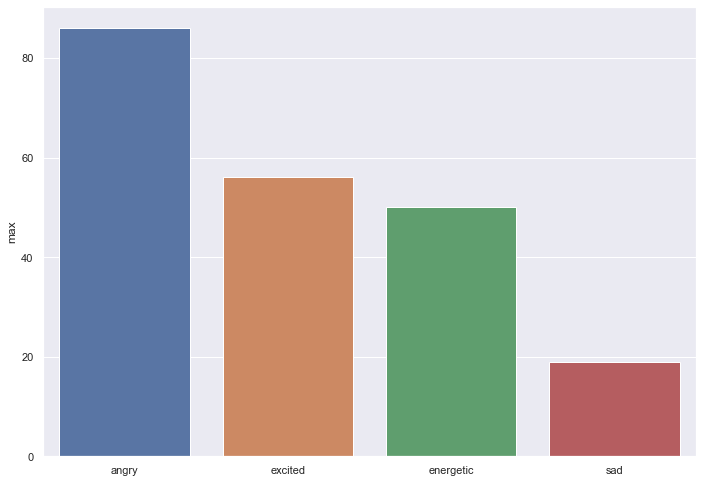

In [207]:
# get the distribution of the correct predictions
correctPreds = y_pred_prob[y_pred == y_test]
#only use the probability of the predicted mood
correctPreds = correctPreds[:,[0,1,2,3]]
correctPredsDF = pd.DataFrame(correctPreds, columns=['sad', 'angry', 'energetic', 'excited'])


correctPredsDF['max'] = correctPredsDF.idxmax(axis=1)


sns.set(style="whitegrid")

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x=correctPredsDF['max'].value_counts().index, y=correctPredsDF['max'].value_counts())
plt.show()

[[19 53 26 25]
 [16 86 17  6]
 [14 19 50 38]
 [15 16 24 56]]


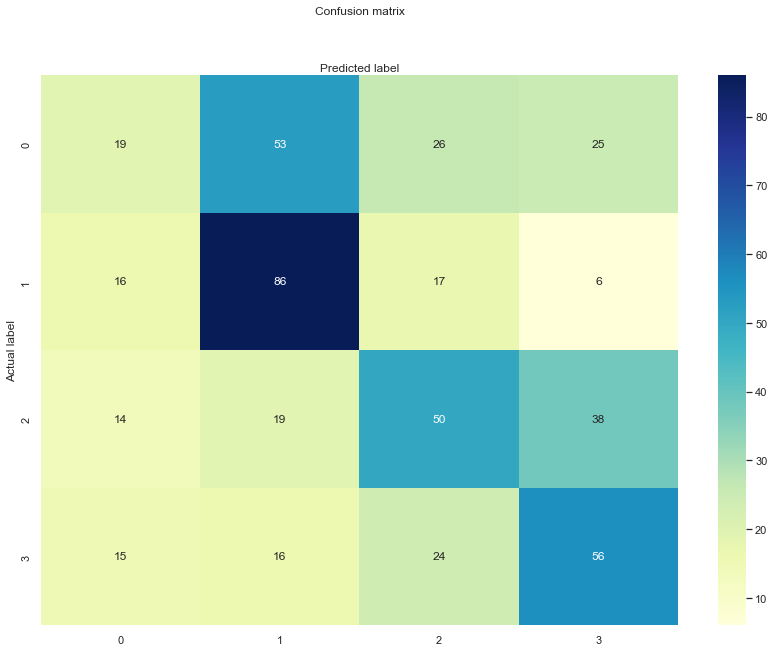

In [191]:


# get the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

# plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

class_names=[0,1,2,3] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.show()

### Random Forest

In [231]:
#use xtrain and ytrain to train the random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print('Accuracy of random forest classifier on test set: {:.2f}'.format(rf.score(X_test, y_test)))

# get the f-1 score for the random forest classifier
f1_score(y_test, y_pred, average='weighted')

Accuracy of random forest classifier on test set: 0.36


0.36020097183319144

In [235]:
y_test.value_counts()

energetic    125
angry        123
excited      121
sad          111
happy          0
content        0
calm           0
depressed      0
Name: mood, dtype: int64

## route 2: break up into 2 low to high problems (in terms of arousal)

## route 3: break up into the 4 quadrants and 4 axes

In [299]:
# create subBalancedDF1, which is a subset of balancedDF, which only includes 4 moods: sad, energetic, happy, calm
subBalancedDF5 = balancedDF[balancedDF['mood'].isin(['sad', 'energetic', 'happy', 'calm'])]
# create subBalancedDF2, which is a subset of balancedDF, which only includes 4 moods: angry, excited, content, depressed
subBalancedDF6 = balancedDF[balancedDF['mood'].isin(['angry', 'excited', 'content', 'depressed'])]


In [280]:
categories5 = ['sad', 'energetic', 'happy', 'calm']
subBalancedDF5['mood'] = pd.Categorical(subBalancedDF5['mood'], categories=categories5, ordered=True)
subBalancedDF5['mood'] = subBalancedDF5['mood'].cat.codes

categories6 = ['angry', 'excited', 'content', 'depressed']
subBalancedDF6['mood'] = pd.Categorical(subBalancedDF6['mood'], categories=categories6, ordered=True)
subBalancedDF6['mood'] = subBalancedDF6['mood'].cat.codes

<ipython-input-280-393acd8b205b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subBalancedDF5['mood'] = pd.Categorical(subBalancedDF5['mood'], categories=categories5, ordered=True)
<ipython-input-280-393acd8b205b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subBalancedDF5['mood'] = subBalancedDF5['mood'].cat.codes
<ipython-input-280-393acd8b205b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [287]:
subBalancedDF6.shape

(2400, 17)

In [288]:
subBalancedDF6.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,duration_ms,time_signature,song,mood,genre
381,0.848,0.520,5,-10.663,0,0.5010,0.002250,0.000799,0.679,0.304,149.996,spotify:track:2XSrt1dcuOXPgl3B4bxmBz,203897,4,Carrollton,0,rap
666,0.713,0.698,10,-7.435,0,0.1680,0.180000,0.000001,0.304,0.480,124.973,spotify:track:1SSv8SA2OHfOUwLgb8yOum,180062,4,Cheat Cxdes,0,rap
257,0.757,0.423,1,-2.311,1,0.0527,0.000004,0.897000,0.118,0.125,130.058,spotify:track:0A8Mrg7ButLr17K3A0R61D,133308,4,TOTALITARIANISM,0,EDM
338,0.516,0.515,1,-13.005,1,0.2790,0.033600,0.000002,0.119,0.396,95.971,spotify:track:583TaS41X2JJGKoGXnTY3l,107159,4,KILLTHEPHARAOH,0,rap
319,0.618,0.836,6,-4.750,0,0.0813,0.002400,0.000000,0.363,0.397,175.060,spotify:track:7CMy59461Q3pgsPZ4Cj8CP,89143,4,EASE,0,rap


In [300]:
# make a classifier for subBalancedDF1, which only takes in valence and energy, and outputs the mood
X6 = subBalancedDF6[['valence','energy', 'key','loudness','mode','danceability', 'acousticness', 'instrumentalness', 'liveness', 'speechiness', 'tempo']]
y6 = subBalancedDF6['mood'].cat.codes

X_train6, X_test6, y_train6, y_test6 = train_test_split(X6, y6, test_size=0.2, random_state=0)

logreg6 = RandomForestClassifier(n_estimators=100, random_state=0)#, solver='lbfgs', multi_class='multinomial')
logreg6.fit(X_train6, y_train6)

y_pred6 = logreg6.predict(X_test6)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg6.score(X_test6, y_test6)))

# get the f-1 score for the classifier
f1_score(y_test6, y_pred6, average='weighted')

Accuracy of logistic regression classifier on test set: 0.62


0.6150181910651408

In [305]:
offByOne(y_test6, y_pred6)

              precision    recall  f1-score   support

           1      0.741     0.650     0.693       123
           3      0.573     0.739     0.646       111
           5      0.621     0.616     0.618       125
           7      0.543     0.471     0.504       121

    accuracy                          0.617       480
   macro avg      0.619     0.619     0.615       480
weighted avg      0.621     0.617     0.615       480



In [302]:
# make a classifier for subBalancedDF1, which only takes in valence and energy, and outputs the mood
X5 = subBalancedDF5[['valence','energy', 'key','loudness','mode','danceability', 'acousticness', 'instrumentalness', 'liveness', 'speechiness', 'tempo']]
y5 = subBalancedDF5['mood'].cat.codes

X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=0.2, random_state=0)
y_pred5 = logreg6.predict(X_test5)


In [304]:
offByOne(y_test5, y_pred5)

              precision    recall  f1-score   support

           0      1.000     0.374     0.544        99
           1      0.000     0.000     0.000         0
           2      1.000     0.752     0.858       129
           3      0.000     0.000     0.000         0
           4      1.000     0.745     0.854       110
           5      0.000     0.000     0.000         0
           6      1.000     0.944     0.971       126
           7      0.000     0.000     0.000         0

    accuracy                          0.722       464
   macro avg      0.500     0.352     0.404       464
weighted avg      1.000     0.722     0.821       464



c:\Users\mlar5\anaconda3\envs\TextMining\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mlar5\anaconda3\envs\TextMining\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mlar5\anaconda3\envs\TextMining\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [309]:
#combine and flatten the two arrays
y_pred56 = np.concatenate((y_pred5, y_pred6), axis=None)

y_test56 = np.concatenate((y_test5, y_test6), axis=None)

In [310]:
offByOne(y_test56, y_pred56)

              precision    recall  f1-score   support

           0      1.000     0.374     0.544        99
           1      0.656     0.650     0.653       123
           2      1.000     0.752     0.858       129
           3      0.461     0.739     0.567       111
           4      1.000     0.745     0.854       110
           5      0.456     0.616     0.524       125
           6      1.000     0.944     0.971       126
           7      0.407     0.471     0.437       121

    accuracy                          0.668       944
   macro avg      0.747     0.661     0.676       944
weighted avg      0.744     0.668     0.681       944

